# Sea ice analyses (maps, timeseries, etc) for ACCESS-OM2 at multiple resolutions
### TODO: 
- compare thickness with cryosat or ICESat data?
- compare with SOSE ice data: http://sose.ucsd.edu/BSOSE6_iter133_solution.html
- compare with MOM6 panantarctic `/scratch/x77/amh157/mom6/archive/mom6-panan`
- compare with Pauthenet et al. SO climatology data: `/g/data/ik11/observations/Southern_Ocean_Climatology_PauthenetETAL2021/TS_Climato_Antarctic60S.nc`

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
import cartopy.crs as ccrs
import cartopy.feature as cft
#from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
import cftime
from datetime import timedelta
from datetime import datetime
import copy
import xesmf
import gzip

#import sys, os
#sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# set up time units and offset to suit CICE 
# see https://github.com/OceansAus/ACCESS-OM2-1-025-010deg-report/commit/ce3b6331bc4f304d2c5f957ccd2a0ae9ca5d6970#commitcomment-31646163
# for e in exptdata.exptdict.keys():
#     exptdata.exptdict[e]['time_units'] = None

# Set up time_units to suit CICE 
# Only retain netcdf time_units for 0.1 deg.
# We need to change time_units of 1deg and 0.25 deg 
# to shift the time so the last cycle starts in 1958.
# But we don't need offset because CICE time starts at beginning of run, 
# unlike MOM which starts in year 0001.
#exptdata.exptdict['01deg']['time_units'] = "days since 1985-01-01"  # don't use None - it leaves the time as cftime

set chio=0.006 in 1deg_control
set chio=0.006 in 1deg_albicei_0.36
set chio=0.006 in 1deg_albicei_0.39
set chio=0.006 in 1deg_albicei_0.47
set chio=0.006 in 1deg_albicev_0.78
set chio=0.006 in 1deg_albicev_0.81
set chio=0.006 in 1deg_albicev_0.9
set chio=0.006 in 1deg_dragio_0.004
set chio=0.006 in 1deg_mu_rdg_2
set chio=0.006 in 1deg_mu_rdg_4
set chio=0.006 in 1deg_mu_rdg_5
set chio=0.006 in 1deg_ndte_240
set chio=0.006 in 1deg_snowpatch_0.005
set chio=0.006 in 1deg_snowpatch_0.01
set chio=0.006 in 1deg_turning_angle_1
set chio=0.006 in 1deg_turning_angle_10
set chio=0.006 in 1deg_turning_angle_12
set chio=0.006 in 1deg_turning_angle_14
set chio=0.006 in 1deg_turning_angle_16
set chio=0.006 in 1deg_turning_angle_18
set chio=0.006 in 1deg_turning_angle_2
set chio=0.006 in 1deg_turning_angle_20
set chio=0.006 in 1deg_turning_angle_22
set chio=0.006 in 1deg_turning_angle_24
set chio=0.006 in 1deg_turning_angle_26
set chio=0.006 in 1deg_turning_angle_3
set chio=0.006 in 1deg_turning_angle

In [2]:
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:41011 Dashboard: /proxy/8787/status,Cluster Workers: 20 Cores: 20 Memory: 190.00 GiB


In [3]:
figdir = 'figs'
dpi=200
if not os.path.exists(figdir):
    os.makedirs(figdir)

def figname(fname, figdir=figdir):
    return os.path.join(figdir, fname+'_'+str(dpi)+'dpi.png')

def savefigure(fname, skip=False):
    if not(os.path.exists(fname) and skip):
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')  # comment out to disable saving
        pass
    return

## Specify date range

In [53]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [54]:
timerange=slice(tstart, tend)
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print('yearrange =', yearrange, 'complete years')
print('tstart =', tstart)
print('tend =', tend)

yearrange = 1993-2017 complete years
tstart = 1993-01-01 00:00:00
tend = 2018-01-01 00:00:00


## Define data loaders

In [7]:
def fixcicetime(da):
    '''
    Correct the time coordinate in DataArray from CICE netcdf file.
    
    CICE netcdf files unhelpfully have a time coordinate which is just after the end of the averaging period, 
    e.g. the time stamp for a January average is 1 February, which messes up groupby month etc.
    
    This function just subtracts 12 hours to put it in the correct month (and day, for daily means).
    
    PR 109 gives an option to fix this:
    https://github.com/OceansAus/cosima-cookbook/pull/109
    
    '''
    try:
        da['time'] = da.time - np.timedelta64(12, 'h')
    except:
        da['time'] = da.time - timedelta(hours=12)  # for 01deg which for some reason uses cftime
    return da

# use this for DataSet: replaces the bad time dimension with the average of time_bounds.
#     The time type is also changed to datetime64[ns]
#     ds['time'] = ds.time_bounds.astype('int64').mean(axis=1).astype('datetime64[ns]')
    

In [8]:
def loaddata(ide, varnames=['aice_m'], timerange=timerange, ncfiles=None, model='cice'):
# load model data
#   NB: varnames must be t-grid variables!!

    grids = [(p, xr.open_dataset(p)) for p in ide['gridpaths']]
    for k in ['xt_ocean', 'yt_ocean', 'geolon_t', 'geolat_t', 'area_t']:
        if k not in ide:
            for (p, g) in grids:
                try:
                    ide[k] = g[k]
                    print(k, 'loaded from', p)
                    break
                except:
                    continue
            try:
                ide[k] = ide[k].rename({'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'}) # fix for 01deg
            except:
                pass

    if not isinstance(ncfiles, list):
        ncfiles = [ncfiles]*len(varnames)  # use the same ncfile for all variables

    for varname, ncfile in zip(varnames, ncfiles):
        if varname not in ide.keys():
            if ncfile is None:
                print('loading', varname)
            else:
                print('loading', varname, 'from', ncfile)                
            var = cc.querying.getvar(ide['expt'], varname, ide['session'], ncfile=ncfile,
                                                 start_time=str(timerange.start),
                                                 end_time=str(timerange.stop+timedelta(hours=12)),  # tweak since fixcicetime hasn't been applied yet
                                                 decode_coords=False)
#             if ide['offset']:
#                 var['time'] = var['time'] + ide['offset']  # BUG: already trimmed by start_time, end_time
            if model.lower()=='cice':
                var = fixcicetime(var).sel(time=timerange)
                # use physical coords instead of indices - ASSUMES VARIABLES ARE ON T GRID!
#                 var.coords['ni'] = ide['xt_ocean'].data
#                 var.coords['nj'] = ide['yt_ocean'].data
                var = var.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))
#                 var = var.assign_coords({'latitude': ide['geolat_t'], 'longitude': ide['geolon_t']})
            else:
                var = var.sel(time=timerange)
            var.coords['xt_ocean'] = ide['xt_ocean'].data
            var.coords['yt_ocean'] = ide['yt_ocean'].data
            var = var.assign_coords({'latitude': ide['geolat_t'], 'longitude': ide['geolon_t']})
            ide[varname] = var
            varmm = var.groupby('time.month').mean('time', skipna=True)
            ide[varname+'_mm'] = varmm

In [9]:
def loadJRA(ide, expt='MRI-JRA55-do-1-4-0', varnames=[], timerange=timerange): #, session=JRAsession):
# load JRA55-do data
    for varname in varnames:
        if varname not in ide.keys():
            print('loading', varname)
            var = cc.querying.getvar(expt, varname, ide['session'],
                                                 start_time=str(timerange.start),
                                                 end_time=str(timerange.stop),
                                                 decode_coords=False)
            var = var.rename(({'lon': 'longitude', 'lat': 'latitude'}))
            var = var.sel(time=timerange)

            ide[varname] = var
            
            vard = var.resample(time='d').mean() # daily averages
            vard.attrs = var.attrs
            ide[varname+'_d'] = vard
            
            varm = var.resample(time='m').mean() # monthly averages
            varm.attrs = var.attrs
            ide[varname+'_m'] = varm

            varmm = var.groupby('time.month').mean('time', skipna=True)
            varmm.attrs = var.attrs
            ide[varname+'_mm'] = varmm

In [10]:
def get_sic_obs(pattern, path='/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3', # from http://nsidc.org/data/G02202
                variable='goddard_merged_seaice_conc_monthly', timerange=timerange): 
    '''
    Return a dataarray from the nc files in path/pattern.
    '''
    dataarrays = []
    files = glob(os.path.join(path, pattern))
    for f in tqdm_notebook(files, leave=False, desc='opening files'):
        dataarrays.append(xr.open_dataset(f, decode_times=False)[variable])
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units })

    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1)) #, np.nan)
    
    # use the same coord names as access-om2 t grid
    dataarray = dataarray.rename(({'xgrid': 'xt_ocean', 'ygrid': 'yt_ocean'}))
    
    # sort by time and select timerange
    dataarray = dataarray.sortby('time').sel(time=timerange)

    return dataarray

In [65]:
def get_giomas(path='/g/data/v45/aek156/giomas/Global_seaice', # from sftp anonymous@pscfiles.apl.uw.edu:/pscfiles/zhang/Global_seaice
                variable='heff', timerange=timerange, varrange=[None, None]): 
    '''
    Return a dataarray of GIOMAS data from the flat binary .gz files in path/variable.H????.gz
    variable defaults to 'heff' but can be any of 'heff', 'area', 'iceprod', 'snow' (and maybe others)
    GIOMAS info: http://psc.apl.washington.edu/zhang/Global_seaice/data.html
    '''
    grids = xr.open_dataset(os.path.join(path, 'heff.H1979.nc.gz'), decode_times=False)  # open this to get grid data
    shape = grids.heff.shape

    xt_ocean = grids.lon_scaler.sel(j=0)  # nominal coordinate - incorrect in Arctic
    # find index at which xt_ocean is non-monotonic, and subtract 360 from all previous longitudes
    xdiff = xt_ocean.diff('i')
    stepindex = list(xdiff).index(xdiff.where(xdiff<0, drop=True))+1
    offset = np.zeros(len(xt_ocean))
    offset[0:stepindex] += -360
    xt_ocean += offset

    yt_ocean = xr.DataArray(np.linspace(grids.lat_scaler.min(), grids.lat_scaler.max(), shape[1]))  # nominal coordinate - incorrect in Arctic
    
    dataarrays = []
    for year in tqdm_notebook(range(timerange.start.year, timerange.stop.year+1), leave=False, desc='opening files'):
        file = os.path.join(path, variable+'.H'+str(year)+'.gz')
        with gzip.open(file, 'rb') as f:
            data=np.frombuffer(f.read(), dtype=np.single).reshape(shape)
#             time = [ cftime.datetime(year, m, 15) for m in range(1,13) ]
            time = [ datetime(year, m, 15) for m in range(1,13) ]
            dataarrays.append(xr.DataArray(data, 
                                           dims=('time', 'yt_ocean', 'xt_ocean'),
                                           coords={'time': time, 'yt_ocean': yt_ocean.data, 'xt_ocean': xt_ocean.data}))
    dataarray = xr.concat(dataarrays, dim='time', coords='all')

    # sort by time and select timerange
    dataarray = dataarray.sortby('time').sel(time=timerange)
    
    dataarray = dataarray.assign_coords({ 'latitude': (['yt_ocean', 'xt_ocean'], grids.lat_scaler.data),
                                          'longitude': (['yt_ocean', 'xt_ocean'], grids.lon_scaler.data) })
    # truncate data to varrange
    if varrange[0] != None:
        dataarray = dataarray.where(dataarray > varrange[0], varrange[0])
    if varrange[1] != None:
        dataarray = dataarray.where(dataarray < varrange[1], varrange[1])

    return dataarray

In [12]:
def obs_mm(obs, groupby='time.month'):
    cobs = obs.groupby(groupby).mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

In [13]:
def obs_mstd(obs, groupby='time.month'):
    cobs = obs.groupby(groupby).std('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

## Load data

### Load ACCESS-OM2 model data

In [14]:
ice_data = exptdata.exptdict

In [15]:
ensemble = [ k for k in ice_data.keys() if len(k.split('_')) > 1 ]
# ensemble = [ k for k in ensemble if ice_data[k][0]['res'] in ['0.25°'] ]

ensemble = [ k for k in ensemble if ice_data[k][0]['res'] in ['1°'] ]


# ensemble = [ k for k in ensemble if ice_data[k][0]['perturbed'] in ['j09_bgmax', None] ]
# ensemble = [ k for k in ensemble if ice_data[k][0]['perturbed'] in ['albicev', None] ]


ensemble = [ k for k in ensemble if ice_data[k][0]['perturbed'] in [None] ]  # control run only
ensemble.sort()
controlkeys = [ k for k in ensemble if ice_data[k][0]['perturbed']==None ]

In [16]:
ensemble = ['1deg_albicev_0.9', '1deg_control']

In [16]:
ensemble

['1deg_control']

In [17]:
controlkeys

['1deg_control']

In [18]:
# for ekey in ice_data.keys():
for ekey in ensemble: # just the ensemble
    print(ekey)
    for ide in ice_data[ekey]:
        loaddata(ide, varnames=['aice_m'])

#         loaddata(ide, varnames=['daidtd_m', 'daidtt_m'])  # area tendency due to dynamics and thermo
#         loaddata(ide, varnames=['dvidtd_m', 'dvidtt_m'])  # volume tendency due to dynamics and thermo
#         loaddata(ide, varnames=['congel_m', 'frazil_m', 'meltt_m', 'meltb_m', 'meltl_m', 'snoice_m', 'evap_ai_m'])  # volume tendency due to dynamics and thermo

        loaddata(ide, varnames=['hi_m'])
#         loaddata(ide, varnames=['hi'])

#         loaddata(ide, varnames=['mld'], model='mom', ncfiles=['ocean-2d-mld-1-daily-mean-ym_%'])


#         loaddata(ide, varnames=['aice'])
#         if ekey == '01deg':
# #             loaddata(ide, varnames=['sea_level', 'surface_temp', 'surface_salt', 'mld'], 
# #                      ncfiles=['ocean-2d-sea_level-1-daily-mean-ym_%', 'ocean-2d-surface_temp-1-daily-mean-ym_%', 'ocean-2d-surface_salt-1-daily-mean-ym_%', 'ocean-2d-mld-1-daily-mean-ym_%'])

#             loaddata(ide, model='mom', varnames=['surface_temp', 'surface_salt', 'mld'], 
#                      ncfiles=['ocean-2d-surface_temp-1-daily-mean-ym_%', 'ocean-2d-surface_salt-1-daily-mean-ym_%', 'ocean-2d-mld-1-daily-mean-ym_%'])
#             ide['sst'] = ide['surface_temp'] # ensure consistent names
#             ide['sss'] = ide['surface_salt'] # ensure consistent names

#         else:
#             loaddata(ide, model='mom', varnames=['sst', 'sss', 'mld'], ncfiles='ocean_daily.nc')
# #             loaddata(ide, varnames=['sea_level', 'sst', 'sss', 'mld'], ncfiles='ocean_daily.nc')

#         break  # only load cycle 1
    
#     break

1deg_control
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
loading aice_m
loading hi_m


### Load SIC observational data

In [19]:
obs_SH = get_sic_obs('south/monthly/*.nc')
obs_SH_mm = obs_mm(obs_SH)

opening files:   0%|          | 0/493 [00:00<?, ?it/s]

In [20]:
obs_SH_mstd = obs_mstd(obs_SH)

In [21]:
# Total ice area timeseries
ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsExtNHFileList.sort()
obsExtSHFileList.sort()

### Load GIOMAS data

In [85]:
GIOMAS = {}
for var, kwargs in \
           {'hi_m': {'variable': 'heff', 'varrange': [0, None]},
            'hs_m': {'variable': 'snow', 'varrange': [0, None]},
            'aice_m': {'variable': 'area', 'varrange': [0, 1]},
            'iceprod_m': {'variable': 'iceprod', 'varrange': [None, None]}
           }.items():
    print('loading', var)
    GIOMAS[var] = get_giomas(**kwargs)
GIOMAS_mm = {k: v.groupby('time.month').mean('time', skipna=True) for k, v in GIOMAS.items()}

loading hi_m


opening files:   0%|          | 0/26 [00:00<?, ?it/s]

loading hs_m


opening files:   0%|          | 0/26 [00:00<?, ?it/s]

loading aice_m


opening files:   0%|          | 0/26 [00:00<?, ?it/s]

loading iceprod_m


opening files:   0%|          | 0/26 [00:00<?, ?it/s]

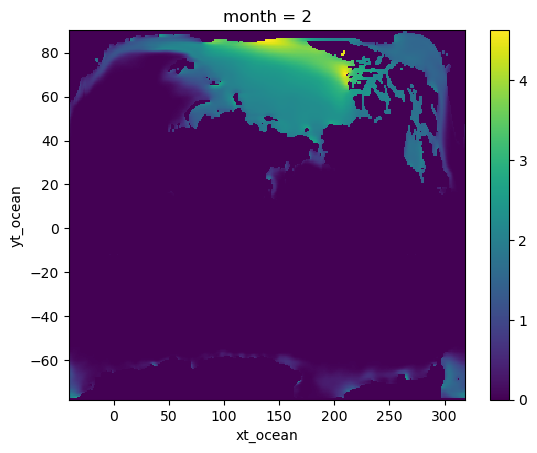

In [87]:
GIOMAS_mm['hi_m'][1].plot()

### Load JRA55-do data
JRA55-do has sea ice concentration `siconc`, `siconca` in

`/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/seaIce`

which is now indexed in the cookbook https://github.com/COSIMA/master_index/issues/11

Presumably these are both from COBE-SST - see JMA2006a, MatsumotoIshiiFukudaHirahara2006a, IshiiShoujiSugimotoMatsumoto2005a
- `siconc` is daily, on the ocean grid
    - .nc metadata: :grid = "1x1 degree latitude x longitude" ;
    - .nc metadata: :nominal_resolution = "100 km" ;
    - continuous range of values
    - presumably this is the original COBE-SST data before the 55% thresholding and regridding
- `siconca` is 3-hourly, on the atmos grid, **assimilated into JRA55**
    - .nc metadata: :grid = "data regridded to the normal atmosphere TL319 gaussian grid (320x640 latxlon) from a reduced TL319 gaussian grid" ;
    - .nc metadata: :nominal_resolution = "50 km" ;
    - almost all values are 0 or 100% (there are a few of 20, 40, 60, 80% at edges of 100% regions, presumably due to iterpolation onto atmos grid, and perhaps in time to get 3-hourly data from daily siconc)
    - so presumably this is within the 55% contour as seen by the atmosphere model
   
so`siconc` is original ice data, `siconca` is thresholded - confirmed by comparing these:

`/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/seaIce/day/siconc/gn/v20190429/siconc_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gn_20180101-20181231.nc`

`/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/seaIce/3hrPt/siconca/gr/v20190429/siconca_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_201801010000-201812312100.nc`


In [21]:
JRA_data = {'session': cc.database.create_session()}

In [22]:
loadJRA(JRA_data, varnames=['siconc'])  # COBE-SST sea ice concentration

loading siconc


In [23]:
loadJRA(JRA_data, varnames=['siconca'])  # COBE-SST sea ice concentration, thresholded daily at 55% and interpolated to 3-hourly - used as input to JRA55 reanalysis

loading siconca


In [143]:
loadJRA(JRA_data, varnames=['uas', 'psl', 'tas', 'rlds', 'rsds']) # also 'vas', ts', 'huss', 'prra', 'prsn'

loading uas
loading psl
loading tas
loading rlds
loading rsds


# Regridders
see https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html
and https://xesmf.readthedocs.io

In [89]:
def mom_regridder(grid_in, grid_out, method='bilinear', periodic=True, **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in and grid_out are paths to MOM grid NetCDF files.
    The regridder maps tracer points to tracer points.
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    def opends(fn):
        try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
            return xr.open_dataset(fn).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})         
        except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
            ds = xr.open_dataset(fn).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
            ds_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                        .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
            return ds.assign_coords({'x': ds_fix['x'], 'y': ds_fix['y']})

    ds_in = opends(grid_in)
    ds_out = opends(grid_out)

    rg = xesmf.Regridder(ds_in, ds_out, method=method, periodic=periodic, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da.chunk({'xt_ocean': None, 'yt_ocean': None}))
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [90]:
def G02202_obs_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a NSIDC G02202 NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                    .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [91]:
def giomas_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a GIOMAS NetCDF grid file, e.g. '/g/data/v45/aek156/giomas/Global_seaice/heff.H1979.nc.gz'
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', 'giomas',
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'i': 'x', 'j': 'y',
                     'lon_scaler': 'lon', 'lat_scaler': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                    .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [92]:
def JRA55_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a JRA55-do NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                    .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [93]:
def JRA55_to_G02202_obs_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a JRA55-do NetCDF grid file
    grid_out -- path to a NSIDC G02202 NetCDF grid file
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)

    ds_out = xr.open_dataset(grid_out)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [94]:
# define regridder functions
regrid_1_to_025 = mom_regridder('/g/data/ik11/grids/ocean_grid_10.nc', '/g/data/ik11/grids/ocean_grid_025.nc')#, method='conservative')
regrid_1_to_01 = mom_regridder('/g/data/ik11/grids/ocean_grid_10.nc', '/g/data/ik11/grids/ocean_grid_01.nc')#, method='conservative')
regrid_025_to_01 = mom_regridder('/g/data/ik11/grids/ocean_grid_025.nc', '/g/data/ik11/grids/ocean_grid_01.nc')#, method='conservative')
regrid_025_to_1 = mom_regridder('/g/data/ik11/grids/ocean_grid_025.nc', '/g/data/ik11/grids/ocean_grid_10.nc')#, method='conservative')
regrid_01_to_1 = mom_regridder('/g/data/ik11/grids/ocean_grid_01.nc', '/g/data/ik11/grids/ocean_grid_10.nc')#, method='conservative')
regrid_01_to_025 = mom_regridder('/g/data/ik11/grids/ocean_grid_01.nc', '/g/data/ik11/grids/ocean_grid_025.nc')#, method='conservative')

In [95]:
obsfile_NH = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/north/monthly/seaice_conc_monthly_nh_f08_198708_v03r01.nc'
regrid_NHobs_to_1 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_10.nc')
regrid_NHobs_to_025 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_025.nc')
regrid_NHobs_to_01 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_01.nc')

obsfile_SH = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/south/monthly/seaice_conc_monthly_sh_f08_198708_v03r01.nc'
regrid_SHobs_to_1 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_10.nc')
regrid_SHobs_to_025 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_025.nc')
regrid_SHobs_to_01 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_01.nc')

obsregridders = {'NH': 
                 {
                     '1°': regrid_NHobs_to_1,
                     '0.25°': regrid_NHobs_to_025,
                     '0.1°': regrid_NHobs_to_01
                 },
                'SH':
                 {
                     '1°': regrid_SHobs_to_1,
                     '0.25°': regrid_SHobs_to_025,
                     '0.1°': regrid_SHobs_to_01
                 }
                }

In [96]:
GIOMAS_file = '/g/data/v45/aek156/giomas/Global_seaice/heff.H1979.nc.gz'
regrid_giomas_to_1 = giomas_regridder(GIOMAS_file, '/g/data/ik11/grids/ocean_grid_10.nc')
regrid_giomas_to_025 = giomas_regridder(GIOMAS_file, '/g/data/ik11/grids/ocean_grid_025.nc')
regrid_giomas_to_01 = giomas_regridder(GIOMAS_file, '/g/data/ik11/grids/ocean_grid_01.nc')

In [41]:
JRA55file = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/seaIce/day/siconc/gn/v20190429/siconc_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gn_19580101-19581231.nc'
JRA_data['siconc_mm_regridded_to_NHobs'] = JRA55_to_G02202_obs_regridder(JRA55file, obsfile_NH)(JRA_data['siconc_mm'])/100.0  # convert from percent
JRA_data['siconc_mm_regridded_to_SHobs'] = JRA55_to_G02202_obs_regridder(JRA55file, obsfile_SH)(JRA_data['siconc_mm'])/100.0  # convert from percent
JRA_data['siconc_mm_regridded_to_mom'] = dict()
JRA_data['siconc_mm_regridded_to_mom']['1°'] = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_10.nc')(JRA_data['siconc_mm'])/100.0  # convert from percent
JRA_data['siconc_mm_regridded_to_mom']['0.25°'] = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_025.nc')(JRA_data['siconc_mm'])/100.0  # convert from percent
JRA_data['siconc_mm_regridded_to_mom']['0.1°'] = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_01.nc')(JRA_data['siconc_mm'])/100.0  # convert from percent

NameError: name 'JRA_data' is not defined

In [ ]:
JRA55file = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/seaIce/3hrPt/siconca/gr/v20190429/siconca_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_201801010000-201812312100.nc'
JRA_data['siconca_mm_regridded_to_NHobs'] = JRA55_to_G02202_obs_regridder(JRA55file, obsfile_NH)(JRA_data['siconca_mm'])/100.0  # convert from percent
JRA_data['siconca_mm_regridded_to_SHobs'] = JRA55_to_G02202_obs_regridder(JRA55file, obsfile_SH)(JRA_data['siconca_mm'])/100.0  # convert from percent
JRA_data['siconca_mm_regridded_to_mom'] = dict()
JRA_data['siconca_mm_regridded_to_mom']['1°'] = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_10.nc')(JRA_data['siconca_mm'])/100.0  # convert from percent
JRA_data['siconca_mm_regridded_to_mom']['0.25°'] = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_025.nc')(JRA_data['siconca_mm'])/100.0  # convert from percent
JRA_data['siconca_mm_regridded_to_mom']['0.1°'] = JRA55_regridder(JRA55file, '/g/data/ik11/grids/ocean_grid_01.nc')(JRA_data['siconca_mm'])/100.0  # convert from percent

# Define map plotter and views

In [98]:
# based on https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb

def plotSIC(var, legend=True, projection=ccrs.NorthPolarStereo(), extent=[-180, 180, 48, 90],
           levels=np.arange(0,1.01,.1), cmp=plt.get_cmap('nipy_spectral'),
           cmap_gamma=2., # NB: non-1 gamma only works for fields and ticklevels in range [0, 1]
           cbar_ticklevels=[0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1],  # for cmap_gamma = 2.
#            cmap_gamma = 4., cbar_ticklevels = [0,.5,.6,.7,.8,.85,.9,.95,.98,1],  # for cmap_gamma = 4.
           cbar_sigfigs=2, cbar_fontsize=12, cbar_label='Sea ice concentration', extend='neither', colorbar=True,
           lon_grid=range(-360, 361, 30), lat_grid=range(-80, 81, 10), draw_gridline_labels=True,
           x='longitude', y='latitude', xtransform=ccrs.PlateCarree(),
           contourvars=[],  # list of (var, label, kwargs) for overlaid contours
           feature=cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor=[.6, .6, .6], 
                                   linewidth=0.25)):
    var = var**cmap_gamma
    plt.figure(figsize=(12,7))
    ax = plt.axes(projection=projection)
#     ax.set_facecolor(cmp(0))
    ax.set_facecolor([.4, .4, .4])
#     ax.coastlines(resolution='50m', linewidth=0.5)
    ax.add_feature(feature)
#     ax.set_global()
    gl = ax.gridlines(draw_labels=draw_gridline_labels,
                      linewidth=0.5, color=[0.8, 0.8, 0.8], alpha=0.5)
    gl.ylabels_top = None

#     gl.ylabels_bottom = None # only needed for Weddell and Amundsen-Bellingshausen closeups
#     gl.ylabels_left = None # only needed for Weddell and Amundsen-Bellingshausen closeups
#     gl.ylabels_right = None # only needed for Weddell and Amundsen-Bellingshausen closeups

#     gl.ylabels_right = None
    gl.xlabels_top = None
    gl.xlabels_bottom = None
    gl.xlabels_left = None
    gl.xlabels_right = None
    gl.xlocator = mticker.FixedLocator(lon_grid)
    gl.ylocator = mticker.FixedLocator(lat_grid)

#     contourf is buggy near poles, so use pcolormesh instead
#    p1 = var.plot.contourf(ax=ax,
#                           x='longitude', y='latitude',
#                           levels=levels, #vmin=0, vmax=1,
#                           cmap=cmp,
#                           transform=ccrs.PlateCarree(),
#                           add_colorbar=False)

#     p1 = exptdata.joinseams(var).plot.pcolormesh(ax=ax,
    p1 = var.plot.pcolormesh(ax=ax,
                           x=x, y=y,
                           vmin=min(cbar_ticklevels), vmax=max(cbar_ticklevels),
                           cmap=cmp,
                           transform=xtransform,
                           add_colorbar=False)

    ax.set_extent(extent, ccrs.PlateCarree())
#     p1.cmap.set_over(color=cmp(255), alpha=None)
#     p1.cmap.set_under(color=cmp(0), alpha=None)
    
    for cv in contourvars:
        cline = cv[0].plot.contour(#, #ax=ax,
            x='longitude', y='latitude',
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            **cv[2])
        if cv[1] is not None:
            cline.collections[0].set_label(cv[1]+' '+str(int(cv[2]['levels'][0]*100))+'%')

#         SeasonSI.sel(season = season).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
#                                                    levels = [contIce], colors = 'white', linewidths = 1,
#                                                    transform = ccrs.PlateCarree())

    if legend:
        plt.legend(prop={'size':8},loc='center')


    if colorbar:
        ax_cb = plt.axes([0.3, 0.08, 0.422, 0.015])
        cbar = plt.colorbar(p1, cax=ax_cb, orientation='horizontal', extend=extend)
        cbar.set_label(cbar_label, size=cbar_fontsize)
        cbar_ticks = [ f**cmap_gamma for f in cbar_ticklevels ]  
        cbar_ticklabels = [str(round(f, cbar_sigfigs)) for f in cbar_ticklevels]
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticklabels)
        cbar_labels = plt.getp(cbar.ax.axes,'xticklabels')
        plt.setp(cbar_labels, fontsize=cbar_fontsize)
    
    return ax

In [99]:
views = {
#     'NH': {'projection': ccrs.NorthPolarStereo(), 'extent': [-180, 180, 48, 90]},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'extent': [-180, 180, -90, -54]},

# for some reason Stereographic doesn't work with JRA55-do data
#     'Amundsen-Bellingshausen': {'projection': ccrs.Stereographic(central_longitude=-90, central_latitude=-70), 'extent': [-115, -60, -77, -63], 'lon_grid': [], 'lat_grid': [], 'draw_gridline_labels': False},

# ... but SouthPolarStereo works with JRA55-do data and looks nearly identical
#     'Amundsen-BellingshausenSP': {'projection': ccrs.SouthPolarStereo(central_longitude=-90), 'extent': [-115, -60, -77, -63], 'lon_grid': [], 'lat_grid': [], 'draw_gridline_labels': False},

#     'Amundsen-Weddell': {'projection': ccrs.Stereographic(central_longitude=-70, central_latitude=-70), 'extent': [-115, -25, -82, -60], 'draw_gridline_labels': False},
#     'Weddell': {'projection': ccrs.Stereographic(central_longitude=-60, central_latitude=-70), 'extent': [-62, -20, -76.5, -60], 'draw_gridline_labels': False},
#     'Weddell-closeup': {'projection': ccrs.Stereographic(central_longitude=-60, central_latitude=-70), 'extent': [-60, -41, -75, -70], 'lon_grid': [], 'lat_grid': [], 'draw_gridline_labels': False}
}

In [100]:
extlevel = [0.15, 0.15+1e-15]  # SIC contour level defining extent 

# Plot maps

## Ice monthly climatologies

### Model SIC

In [32]:
# plot monthly SIC climatologies from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #enumerate(ice_data.keys()): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice_m_mm']:
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)
                        idev1 = ice_data[ekey+'v1'][cycle-1]
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                        
                        print('doing', fname)
                        plotSIC(v, contourvars=[
                                (idev1[var].sel(month=m), idev1['desc'], {'levels': extlevel, 'colors': 'C'+str(enum+3)}), # 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}), # old v1 config
                                (v, ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ],
                                **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
            break
#         break
print('done')

SH


KeyError: '025deg_albicev_0.9v1'

In [33]:
# plot monthly SIC climatologies from each cycle of each model, with SIC set to 0 for hi < hithreshold
hithreshold = .2  # thickness threshold (m)
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #enumerate(ice_data.keys()): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice_m']:
                vthresh_m = ide[var].where(ide['hi_m'] > hithreshold, 0.0)
                vthresh_m_mm = vthresh_m.groupby('time.month').mean('time', skipna=True)
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([viewname, var+'_mm', 'hithreshold', str(hithreshold), 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = vthresh_m_mm.sel(month=m)
#                         idev1 = ice_data[ekey+'v1'][cycle-1]
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                        
                        print('doing', fname)
                        plotSIC(v, contourvars=[
#                                 (idev1[var].sel(month=m), idev1['desc'], {'levels': extlevel, 'colors': 'C'+str(enum+3)}), # 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}), # old v1 config
                                (v, ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ], cbar_label='Sea ice concentration for thickness > '+str(hithreshold)+'m',
                                **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
#             break
#         break
print('done')

SH
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_06_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_07_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_month_08_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0

In [36]:
# plot monthly SIC climatology for perturbations
controlkey = controlkeys[0]  # KLUDGE! do this better
control = ice_data[controlkey][0]
for var in ['aice_m_mm']:
    for m in range(1,13):
        vcontrol = control[var].sel(month=m)
        for ekey in ensemble: #ice_data.keys():
            for viewname, view in views.items():
                if viewname in ['NH']:
                    hem = 'NH'
                else:
                    hem = 'SH'
                ide = ice_data[ekey][0]
                title = ' '.join([ide['desc'], yearrange, calendar.month_name[m], 'mean'])
                fname = figname('_'.join([viewname, var, 
                                          ide['expt'], yearrange, 'mean', 'month', str(m).zfill(2)]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = ide[var].sel(month=m)
                    obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)

                    print('doing', fname)
                    contourvars=[
                            (vcontrol, control['desc'], {'levels': extlevel, 'colors': 'green'}),
                            (v, ide['desc'], {'levels': extlevel, 'colors': 'y'}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                            (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'silver'}),
                            (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'silver'}),
                            ]
                    if ekey == controlkey:
                        contourvars = contourvars[0:1]+contourvars[2:]
                    plotSIC(v, contourvars=contourvars, **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#             break
#         break
print('done')

doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_01_200dpi.png
   -- skipping figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_02_200dpi.png
   -- skipping figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_03_200dpi.png
   -- skipping figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_04_200dpi.png
   -- skipping figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_05_200dpi.png
   -- skipping figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ense

In [37]:
# plot monthly SIC climatology for perturbations, with SIC set to 0 for hi < hithreshold
hithreshold = .2  # thickness threshold (m)
controlkey = controlkeys[0]  # KLUDGE! do this better
control = ice_data[controlkey][0]
for var in ['aice_m']:
    vcontrolthresh_m = control[var].where(ide['hi_m'] > hithreshold, 0.0)
    vcontrolthresh_m_mm = vcontrolthresh_m.groupby('time.month').mean('time', skipna=True)
    for ekey in ensemble: #ice_data.keys():
        ide = ice_data[ekey][0]
        vthresh_m = ide[var].where(ide['hi_m'] > hithreshold, 0.0)
        vthresh_m_mm = vthresh_m.groupby('time.month').mean('time', skipna=True)
        for m in range(1,13):
            vcontrol = vcontrolthresh_m_mm.sel(month=m)
            for viewname, view in views.items():
                if viewname in ['NH']:
                    hem = 'NH'
                else:
                    hem = 'SH'
                title = ' '.join([ide['desc'], yearrange, calendar.month_name[m], 'mean'])
                fname = figname('_'.join([viewname, var+'_mm', 'hithreshold', str(hithreshold),
                                          ide['expt'], yearrange, 'mean', 'month', str(m).zfill(2)]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = vthresh_m_mm.sel(month=m)
                    obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)

                    print('doing', fname)
                    contourvars=[
                            (vcontrol, control['desc'], {'levels': extlevel, 'colors': 'g'}),
                            (v, ide['desc'], {'levels': extlevel, 'colors': 'y'}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                            (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'silver'}),
                            (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'silver'}),
                            ]
                    if ekey == controlkey:
                        contourvars = contourvars[0:1]+contourvars[2:]
                    plotSIC(v, contourvars=contourvars, 
                            cbar_label='Sea ice concentration for thickness > '+str(hithreshold)+'m',
                            **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#             break
#         break
print('done')

doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_06_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_07_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_month_08_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9_1993-2017_mean_mon

### Model SIC differences

In [ ]:
# plot monthly SIC climatology difference between cycle n and cycle 1 for each model
for viewname, view in views.items():
    print(viewname)
    for ekey in ice_data.keys(): #['1deg']: #['01deg']: #['025deg']:
        for var in ['aice_m_mm']:
            for m in range(1,13):
                vref = ice_data[ekey][0][var].sel(month=m)
                for cycle, ide in enumerate(ice_data[ekey][1:], start=2):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
#                     title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean', 'minus cycle 1'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle)+'-cycle1', # FRAGLE! assumes filename cycle number = cycm2+1
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                       print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m) - vref
                        print('doing', fname)
                        plotSIC(v, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus cycle 1',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-.15,.1501,.05), cbar_sigfigs=2, **view).set_title(title);
                        savefigure(fname)
                        plt.close()
print('done')

In [38]:
# plot monthly SIC climatology difference between control and perturbation
controlkey = controlkeys[0]  # KLUDGE! do this better
control = ice_data[controlkey][0]
for var in ['aice_m_mm']:
    for m in range(1,13):
        vcontrol = control[var].sel(month=m)
        for ekey in ensemble[1:]: #ice_data.keys():
            if ekey != controlkey:
                for viewname, view in views.items():
                    if viewname in ['NH']:
                        hem = 'NH'
                    else:
                        hem = 'SH'
                    ide = ice_data[ekey][0]
                    title = ' '.join([ide['desc'], yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'], '-control', yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)
                        vdiff = v - vcontrol
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)

                        print('doing', fname)
                        plotSIC(vdiff, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus control',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-.15,.1501,.05), cbar_sigfigs=2, 
                                contourvars=[
                                (vcontrol, control['desc'], {'levels': extlevel, 'colors': 'lime'}),
                                (v, ide['desc'], {'levels': extlevel, 'colors': 'y'}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'silver'}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'silver'}),
                                ], **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#             break
#         break
print('done')

done


### Observed SIC

In [61]:
# plot monthly climatologies from SIC obs
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        title = ' '.join(['Passive microwave', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, 'aice', 'obs', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if False: #os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            v = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            print('doing', fname)
            plotSIC(v, #x='xt_ocean', y='ygrid', xtransform=ccrs.SouthPolarStereo(),
                    contourvars=[
                    (v.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (v.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'white'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#             break
print('done')

SH
doing figs/SH_aice_obs_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_06_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_07_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_08_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_09_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_10_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_11_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_12_200dpi.png
done


### Model SIC bias (model minus observed)

In [39]:
# plot monthly SIC climatology bias for each model
controlkey = controlkeys[0]  # KLUDGE! do this better
# controlkey = '025deg'
control = ice_data[controlkey][0]
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #['1deg']: #['025deg']: #['01deg']: #
        obsv = eval('_'.join(['obs', hem, 'mm']))
        vrefs = obsregridders[hem][ice_data[ekey][0]['res']](obsv)
        for var in ['aice_m_mm']:
            for m in range(1,13):
                vref = vrefs.sel(month=m)
                for cycle, ide in enumerate(ice_data[ekey], start=1):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'bias'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle)+'-obs', # FRAGLE! assumes filename cycle number = cycm2+1
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        vcontrol = control[var].sel(month=m)
                        v = ide[var].sel(month=m)
                        bias = v - vref
                        print('doing', fname)
                        contourvars=[
                                (vcontrol, control['desc'], {'levels': extlevel, 'colors': 'g'}),
                                (v, ide['desc'], {'levels': extlevel, 'colors': 'm'}),
                                (vref, 'passive microwave',  {'levels': extlevel, 'colors': 'k'})
                                ]
                        if ekey == controlkey:
                            contourvars = contourvars[0:1]+contourvars[2:]
                        plotSIC(bias, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus passive microwave obs',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                                contourvars=contourvars, **view).set_title(title);

                        savefigure(fname)
                        plt.close()
#                     break
#                 break
#             break
#         break
print('done')

SH
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_06_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_07_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_08_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1-obs_1993-2017_mean_month_09_200dpi.png
doing figs/SH_aice_m_mm_0

In [40]:
# plot monthly SIC climatology bias for each model, with model SIC set to 0 for hi < hithreshold
hithreshold = .2  # thickness threshold (m)
controlkey = controlkeys[0]  # KLUDGE! do this better
control = ice_data[controlkey][0]
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #['1deg']: #['025deg']: #['01deg']: #
        ide = ice_data[ekey][0]
        obsv = eval('_'.join(['obs', hem, 'mm']))
        vrefs = obsregridders[hem][ice_data[ekey][0]['res']](obsv)
        for var in ['aice_m']:
            vthresh_m = ide[var].where(ide['hi_m'] > hithreshold, 0.0)
            vthresh_m_mm = vthresh_m.groupby('time.month').mean('time', skipna=True)
            vcontrolthresh_m = control[var].where(ide['hi_m'] > hithreshold, 0.0)
            vcontrolthresh_m_mm = vcontrolthresh_m.groupby('time.month').mean('time', skipna=True)
            for m in range(1,13):
                vref = vrefs.sel(month=m)
#                 for cycle, ide in enumerate(ice_data[ekey], start=1):
                title = ' '.join([ide['desc'], # 'cycle', str(cycle), 
                                  yearrange, calendar.month_name[m], 'bias'])
                fname = figname('_'.join([viewname, var+'_mm', 'hithreshold', str(hithreshold),
                                          ide['expt'].split('_cycle')[0]+'-obs', #'cycle'+str(cycle)+'-obs', # FRAGLE! assumes filename cycle number = cycm2+1
                                          yearrange, 'mean', 'month', str(m).zfill(2)]))
                if os.path.exists(fname):
                   print('   -- skipping', fname)
                else:
                    vcontrol = vcontrolthresh_m_mm.sel(month=m)
                    v = vthresh_m_mm.sel(month=m)
                    bias = v - vref
                    print('doing', fname)
                    contourvars=[
                            (vcontrol, control['desc'], {'levels': extlevel, 'colors': 'g'}),
                            (v, ide['desc'], {'levels': extlevel, 'colors': 'm'}),
                            (vref, 'passive microwave',  {'levels': extlevel, 'colors': 'k'})
                            ]
                    if ekey == controlkey:
                        contourvars = contourvars[0:1]+contourvars[2:]
                    plotSIC(bias, cmp=plt.get_cmap('seismic'), cbar_label='SIC (for thickness > '+str(hithreshold)+'m) minus passive microwave obs',
                            cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                            contourvars=contourvars, **view).set_title(title);

                    savefigure(fname)
                    plt.close()
#                 break
#                 break
#             break
#         break
print('done')

SH
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_06_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_07_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ensemble_albicev_0.9-obs_1993-2017_mean_month_08_200dpi.png
doing figs/SH_aice_m_mm_hithreshold_0.2_025deg_jra55_iaf_ense

In [41]:
# plot monthly SIC climatology bias for each model relative to siconca (which what assimilated into JRA55) and siconc
controlkey = controlkeys[0]  # KLUDGE! do this betvter
# # controlkey = '025deg'
control = ice_data[controlkey][0]
for JRAvar in ['siconca', 'siconc']:
    for viewname, view in views.items():
        print(viewname)
        if viewname in ['NH']:
            hem = 'NH'
        else:
            hem = 'SH'
        for enum, ekey in enumerate(ensemble): #['1deg']: #['025deg']: #['01deg']: #
            obss = obsregridders[hem][ice_data[ekey][0]['res']](eval('_'.join(['obs', hem, 'mm'])))
            vrefs = JRA_data[JRAvar+'_mm_regridded_to_mom'][ice_data[ekey][0]['res']]
            for var in ['aice_m_mm']:
                for m in range(1,13):
                    vref = vrefs.sel(month=m)
                    for cycle, ide in enumerate(ice_data[ekey], start=1):
                        title = ' '.join([ide['desc'], #'cycle', str(cycle), 
                                          yearrange, calendar.month_name[m], 'minus JRA55', JRAvar])
                        fname = figname('_'.join([viewname, var, 
                                                  ide['expt'].split('_cycle')[0], 'cycle'+str(cycle)+'-'+JRAvar, # FRAGLE! assumes filename cycle number = cycm2+1
                                                  yearrange, 'mean', 'month', str(m).zfill(2)]))
                        if os.path.exists(fname):
                           print('   -- skipping', fname)
                        else:
                            vcontrol = control[var].sel(month=m)
                            v = ide[var].sel(month=m)
                            bias = v - vref
                            print('doing', fname)
                            contourvars=[
                                    (vcontrol, control['desc'], {'levels': extlevel, 'colors': 'g'}),
                                    (v, ide['desc'], {'levels': extlevel, 'colors': 'm'}),
                                    (vref, JRAvar,  {'levels': extlevel, 'colors': 'dimgray'}),
                                    (obss.sel(month=m), 'passive microwave',  {'levels': extlevel, 'colors': 'k'})
                                    ]
                            if ekey == controlkey:
                                contourvars = contourvars[0:1]+contourvars[2:]
                            plotSIC(bias, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus JRA55 '+JRAvar,
                                    cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                                    contourvars=contourvars, **view).set_title(title);

                            savefigure(fname)
                            plt.close()
#                         break
#                     break
#                 break
#             break
print('done')

SH


NameError: name 'JRA_data' is not defined

### Model SIC standard deviation

In [42]:
# plot standard deviation of monthly SIC from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #enumerate(ice_data.keys()): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice_m']:
                varstd = ide[var].groupby('time.month').std('time', skipna=True)
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean standard deviation'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'std', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = varstd.sel(month=m)
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                        
                        print('doing', fname)
                        plotSIC(v, cbar_label='Standard deviation of monthly mean sea ice concentration',
                                contourvars=[
                                (ide[var+'_mm'].sel(month=m), ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ],
                                **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
#             break
#         break
print('done')

SH
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_01_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_02_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_03_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_04_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_05_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_06_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_07_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_08_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_09_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_std_month_10_200dpi.p

### Observed SIC standard deviation

In [53]:
# plot standard deviation of monthly mean of SIC obs
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        title = ' '.join(['Passive microwave', yearrange, calendar.month_name[m], 'mean standard deviation'])
        fname = figname('_'.join([viewname, 'aice', 'obs', yearrange, 'std', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            vstd = eval('_'.join(['obs', hem, 'mstd'])).sel(month=m)
            v = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            print('doing', fname)
            plotSIC(vstd, cbar_label='Standard deviation of monthly mean sea ice concentration',
                    contourvars=[
                    (v.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (v.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'white'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#             break
print('done')

SH
doing figs/SH_aice_obs_1993-2017_std_month_01_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_02_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_03_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_04_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_05_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_06_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_07_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_08_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_09_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_10_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_11_200dpi.png
doing figs/SH_aice_obs_1993-2017_std_month_12_200dpi.png
done


### SIC tendency

In [43]:
# plot monthly SIC tendency climatology from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #enumerate(ice_data.keys()): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice_m_mm']:
                for m in range(1,13):
                    prevm = (m-2)%12 + 1
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean tendency'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'mean', 'tendency', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m) - ide[var].sel(month=prevm)
#                         idev1 = ice_data[ekey+'v1'][0]
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                        
                        print('doing', fname)
                        plotSIC(v, cmp=plt.get_cmap('seismic'), cbar_label='SIC change from previous month',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                                contourvars=[
#                                 (idev1[var].sel(month=m), idev1['desc'], {'levels': extlevel, 'colors': 'C'+str(enum+3)}), # 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}), # old v1 config
                                (ide[var].sel(month=m), ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ],
                                **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
#             break # cycle 1 only
#         break
print('done')

SH
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_01_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_02_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_03_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_04_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_05_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_06_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_07_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_month_08_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mean_tendency_

In [41]:
# plot monthly tendency climatologies from SIC obs
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        prevm = (m-2)%12 + 1
        title = ' '.join(['Passive microwave', yearrange, calendar.month_name[m], 'mean tendency'])
        fname = figname('_'.join([viewname, 'aice', 'obs', yearrange, 'mean', 'tendency', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            obs = eval('_'.join(['obs', hem, 'mm']))
            v = obs.sel(month=m)
            tendency = obs.sel(month=m) - obs.sel(month=prevm)
            print('doing', fname)
            plotSIC(tendency, cmp=plt.get_cmap('seismic'), cbar_label='SIC change from previous month',
                    cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                    contourvars=[
                    (v.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (v.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'black'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#             break
print('done')

SH
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_01_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_02_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_03_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_04_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_05_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_06_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_07_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_08_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_09_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_10_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_11_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_tendency_month_12_200dpi.png
done


In [44]:
# plot monthly SIC tendency climatology bias for each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #enumerate(ice_data.keys()): #['1deg']: #['025deg']: #['01deg']: #
        obs = obsregridders[hem][ice_data[ekey][0]['res']](eval('_'.join(['obs', hem, 'mm'])))
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice_m_mm']:
                for m in range(1,13):
                    prevm = (m-2)%12 + 1
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'tendency bias'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'tendency', 'bias', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m) - ide[var].sel(month=prevm)
                        obsv = obs.sel(month=m)
                        obstendency = obs.sel(month=m) - obs.sel(month=prevm)
                        bias = v - obstendency
                        print('doing', fname)
                        plotSIC(bias, cmp=plt.get_cmap('seismic'), cbar_label='Bias (model-obs) in SIC change from previous month',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                                contourvars=[
                                (ide[var].sel(month=m), ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ],
                                **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
#             break # cycle 1 only
#         break
print('done')

SH
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_01_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_02_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_03_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_04_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_05_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_06_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_07_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_month_08_200dpi.png
doing figs/SH_aice_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_tendency_bias_

### SIC tendency components

- `daidtd` is %/day SIC change due to dynamics
- `daidtt` is %/day SIC change due to thermodynamics

In [46]:
# plot monthly SIC tendency components from each cycle of each model
cause = {'daidtd_m_mm':'dynamics', 'daidtt_m_mm': 'thermo'}
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for enum, ekey in enumerate(ensemble): #enumerate(ice_data.keys()): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['daidtd_m_mm', 'daidtt_m_mm']:
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], cause[var], 'tendency'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, cause[var], 'tendency', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)*calendar.monthrange(2021, m)[1]/100  # convert from %/day to SIC change over month (ignoring leap years)
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                        
                        print('doing', fname)
                        plotSIC(v, cmp=plt.get_cmap('seismic'), cbar_label='SIC change over month due to '+cause[var],
                                cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                                contourvars=[
                                (ide['aice_m_mm'].sel(month=m), ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'black'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ],
                                **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
#             break # cycle 1 only
#         break
print('done')

SH
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_01_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_02_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_03_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_04_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_05_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_06_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_07_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_dynamics_tendency_month_08_200dpi.png
doing figs/SH_daidtd_m_mm_025deg_jra55_iaf_en

### Thickness

In [37]:
# plot monthly ice thickness climatologies from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 2.501, 0.5)
    for enum, ekey in enumerate(ensemble):
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['hi_m_mm']:
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)
                        vsic = ide['aice_m_mm'].sel(month=m)
                        obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)

                        print('doing', fname)
#                         plotSIC(v, cbar_label='Sea ice thickness (m)',
#                                 cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max', **view).set_title(title);
                        plotSIC(v, cbar_label='Sea ice thickness (m)',
                                cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max',
                                contourvars=[
#                                 (idev1[var].sel(month=m), idev1['desc'], {'levels': extlevel, 'colors': 'C'+str(enum+3)}), # 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}), # old v1 config
                                (vsic, ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                                (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                                (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                        ],
                                **view).set_title(title);

                        savefigure(fname)
                        plt.close()
#                         break
            break
print('done')

SH
   -- skipping figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_01_200dpi.png
   -- skipping figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_02_200dpi.png
   -- skipping figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_03_200dpi.png
   -- skipping figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_04_200dpi.png
   -- skipping figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_05_200dpi.png
doing figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_06_200dpi.png
doing figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_07_200dpi.png
doing figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_08_200dpi.png
doing figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_09_200dpi.png
doing figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_month_10_200dpi.png
doing figs/SH_hi_m_mm_1deg_jra55_iaf_ensemble_cycle1_1993-2017_mean_mont

SH
doing figs/SH_hi_m_mm_GIOMAS_1993-2017_mean_month_01_200dpi.png
done


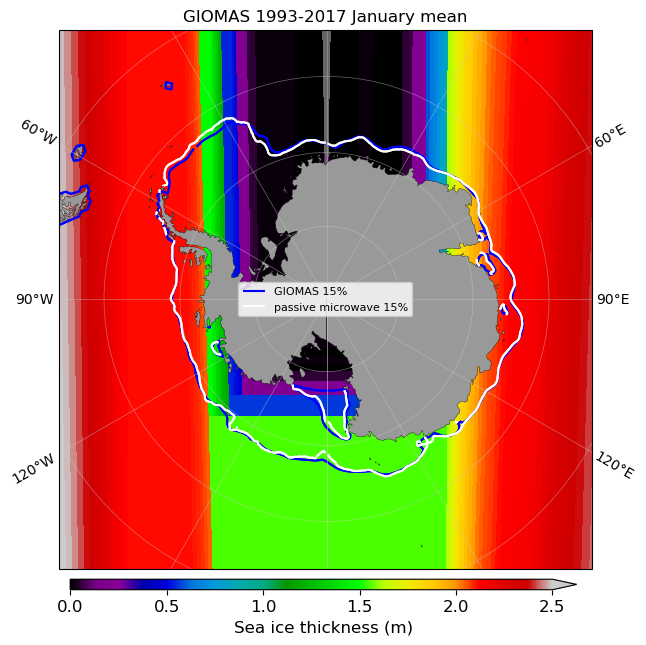

In [81]:
# plot monthly climatologies of SIT from GIOMAS
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 2.501, 0.5)
    for m in range(1,13):
        title = ' '.join(['GIOMAS', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, 'hi_m_mm', 'GIOMAS', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if False: #os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            v = GIOMAS_hi_m_mm.sel(month=m)
            vsic = GIOMAS_aice_m_mm.sel(month=m)
            obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)

            print('doing', fname)
#             plotSIC(v, cbar_label='Sea ice thickness (m)',
#                     cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max', **view).set_title(title);
            plotSIC(v, cbar_label='Sea ice thickness (m)',
                    cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max',
                    contourvars=[
#                                 (idev1[var].sel(month=m), idev1['desc'], {'levels': extlevel, 'colors': 'C'+str(enum+3)}), # 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}), # old v1 config
#                     (vsic, ide['desc'], {'levels': extlevel, 'colors': 'C'+str(enum)}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                    (vsic.isel(xt_ocean=slice(0, 41)), 'GIOMAS',     {'levels': extlevel, 'colors': 'b'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (vsic.isel(xt_ocean=slice(41, None)), None,     {'levels': extlevel, 'colors': 'b'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave',     {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, None)), None, {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
            ],
                    **view).set_title(title);

#             savefigure(fname)
#             plt.close()
            break
print('done')

## GIOMAS

### GIOMAS SIC

In [112]:
# plot monthly SIC climatologies from GIOMAS
vname = 'aice_m'
vdata = GIOMAS_mm[vname]
vdata_regridded = regrid_giomas_to_025(vdata)
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        title = ' '.join(['GIOMAS', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, vname, 'GIOMAS', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            v = vdata_regridded.sel(month=m)
            obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            print('doing', fname)
# TODO: fix gap in data at zonal join
            plotSIC(v, #x='xt_ocean', y='ygrid', xtransform=ccrs.SouthPolarStereo(),
                    contourvars=[
# TODO: 15% contour for GIOMAS 
#                     (v.sel(xt_ocean=slice(-10, 0)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(0, 41)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(41, None)), None, {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, None)), None, {'levels': extlevel, 'colors': 'white'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#                 break
#     break
print('done')

SH
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_01_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_02_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_03_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_04_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_05_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_06_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_07_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_08_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_09_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_10_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_11_200dpi.png
   -- skipping figs/SH_aice_m_GIOMAS_1993-2017_mean_month_12_200dpi.png
done


### GIOMAS SIT

In [110]:
# plot monthly SIT climatologies from GIOMAS
vname = 'hi_m'
vdata = GIOMAS_mm[vname]
vdata_regridded = regrid_giomas_to_025(vdata)
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        title = ' '.join(['GIOMAS', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, vname, 'GIOMAS', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            if viewname == 'NH':
                cbar_ticklevels=np.arange(0, 5.01, 1.0)
            elif viewname == 'Amundsen-Bellingshausen':
                cbar_ticklevels=np.arange(0, 3.501, 0.5)
            else:
                cbar_ticklevels=np.arange(0, 2.501, 0.5)
            v = vdata_regridded.sel(month=m)
            obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            print('doing', fname)
# TODO: fix gap in data at zonal join
            plotSIC(v, cbar_label='Sea ice thickness (m)',
                                cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max',
                    contourvars=[
# TODO: 15% contour for GIOMAS 
#                     (v.sel(xt_ocean=slice(-10, 0)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(0, 41)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(41, None)), None, {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, None)), None, {'levels': extlevel, 'colors': 'white'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#             break
#     break
print('done')

SH
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_01_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_02_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_03_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_04_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_05_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_06_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_07_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_08_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_09_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_10_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_11_200dpi.png
doing figs/SH_hi_m_GIOMAS_1993-2017_mean_month_12_200dpi.png
done


### GIOMAS snow thickness

In [119]:
# plot monthly snow thickness climatologies from GIOMAS
vname = 'hs_m'
vdata = GIOMAS_mm[vname]
vdata_regridded = regrid_giomas_to_025(vdata)
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 0.2501, 0.05)
    for m in range(1,13):
        title = ' '.join(['GIOMAS', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, vname, 'GIOMAS', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            v = vdata_regridded.sel(month=m)
            obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            print('doing', fname)
# TODO: fix gap in data at zonal join
            plotSIC(v, cbar_label='Snow thickness (m)',
                                cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=2, extend='max',
                    contourvars=[
# TODO: 15% contour for GIOMAS 
#                     (v.sel(xt_ocean=slice(-10, 0)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(0, 41)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(41, None)), None, {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'white'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, None)), None, {'levels': extlevel, 'colors': 'white'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#             break
#     break
print('done')

SH
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_01_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_02_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_03_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_04_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_05_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_06_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_07_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_08_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_09_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_10_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_11_200dpi.png
doing figs/SH_hs_m_GIOMAS_1993-2017_mean_month_12_200dpi.png
done


### GIOMAS SIC bias

In [106]:
# plot bias in GIOMAS SIC monthly climatologies relative to NSIDC (GIOMAS - NSIDC)
vname = 'aice_m'
vdata = GIOMAS_mm[vname]
vdata_regridded = regrid_giomas_to_025(vdata)
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        title = ' '.join(['GIOMAS', vname, yearrange, calendar.month_name[m], 'bias'])
        fname = figname('_'.join([viewname, vname, 'GIOMAS-obs', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            v = vdata_regridded.sel(month=m)
            obsv = eval('regrid_'+hem+'obs_to_025('+'_'.join(['obs', hem, 'mm'])+')').sel(month=m)
            bias = v-obsv
            print('doing', fname)
# TODO: fix gap in data at zonal join
            plotSIC(bias, cmp=plt.get_cmap('seismic'), cbar_label='GIOMAS SIC minus passive microwave obs',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-1, 1.01, 0.25), cbar_sigfigs=2,
                    contourvars=[
# TODO: 15% contour for GIOMAS 
#                     (v.sel(xt_ocean=slice(-10, 0)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(0, 41)), 'GIOMAS', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
#                     (v.isel(xt_ocean=slice(41, None)), None, {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (obsv.isel(xt_ocean=slice(0, 158)), 'passive microwave', {'levels': extlevel, 'colors': 'k'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, None)), None, {'levels': extlevel, 'colors': 'k'})], #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    **view).set_title(title);
            savefigure(fname)
            plt.close()
#             break
print('done')

SH
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_05_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_06_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_07_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_08_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_09_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_10_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_11_200dpi.png
doing figs/SH_aice_m_GIOMAS-obs_1993-2017_mean_month_12_200dpi.png
done


## Ice daily

### Concentration

In [49]:
# plot daily SIC obs
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        indata = obs_NH_daily
    else:
        indata = obs_SH_daily
    for date in indata['time'].data[213:578]:
        datestr = np.datetime_as_string(date, unit='D')
        title = ' '.join(['Passive microwave', datestr])
        fname = figname('_'.join([viewname, 'aice', 'obs', datestr]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            v = indata.sel(time=date)
            print('doing', fname)
            plotSIC(v, **view).set_title(title);
            savefigure(fname)
            plt.close()
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-09_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-10_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-11_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-12_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-13_200dpi.png
   -- skipping

In [ ]:
# plot daily SIC from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    for ekey in ice_data.keys():
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice']:
                for date in ide[var]['time'].data: #[213:578]:
                    datestr = date.strftime('%Y-%m-%d')
                    if datestr[0:7] == '2017-01':
                        title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                        fname = figname('_'.join([viewname, var, 
                                                  ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                                  datestr]))
                        if os.path.exists(fname):
                            print('   -- skipping', fname)
                        else:
                            v = ide[var].sel(time=date)
                            print('doing', fname)
                            plotSIC(v, **view).set_title(title);
                            savefigure(fname)
                            plt.close()
    #                         break
#             break  # only do cycle 1
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2017-01-09_200dpi.png
   -- skipping figs/Amundsen-Be

### Thickness

In [26]:
# plot daily ice thickness from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 2.501, 0.5)
    for ekey in ['01deg']: #ice_data.keys():
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['hi']:
                for date in ide[var]['time'].data: #[213:578]:
                    datestr = date.strftime('%Y-%m-%d')
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              datestr]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(time=date)
                        print('doing', fname)
                        plotSIC(v, legend=False, cbar_label='Sea ice thickness (m)',
                                cmp=cm.cm.ice,
                                cmap_gamma=1.0, cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max', **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
            break  # only do cycle 1
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-09_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_01deg_jra55v140_iaf_cycle1_2016-01-10_200dpi.png
   -- skipping f

## Ocean daily

In [23]:
# plot daily MLD from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    for ekey in ['01deg']: #ice_data.keys():
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['mld']:
                for date in ide[var]['time'].data:
                    datestr = date.strftime('%Y-%m-%d')
                    if True: #datestr[0:7] == '2017-01':
                        title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                        fname = figname('_'.join([viewname, var, 
                                                  ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                                  datestr]))
                        if os.path.exists(fname):
                            print('   -- skipping', fname)
                        else:
                            v = ide[var].sel(time=date)
                            print('doing', fname)
                            plotSIC(v, legend=False, cbar_label='Mixed layer depth (m)', cmp=cm.cm.thermal_r,
                                cmap_gamma=1.0, cbar_ticklevels=np.arange(0, 50, 10), cbar_sigfigs=1, **view).set_title(title);
                            savefigure(fname)
                            plt.close()
#                             break
            break  # only do cycle 1
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-09_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_mld_01deg_jra55v140_iaf_cycle1_2016-01-10_200dpi.png
   -- 

Amundsen-Bellingshausen
doing figs/Amundsen-Bellingshausen_sss_01deg_jra55v140_iaf_cycle1_2017-01-01_200dpi.png
done


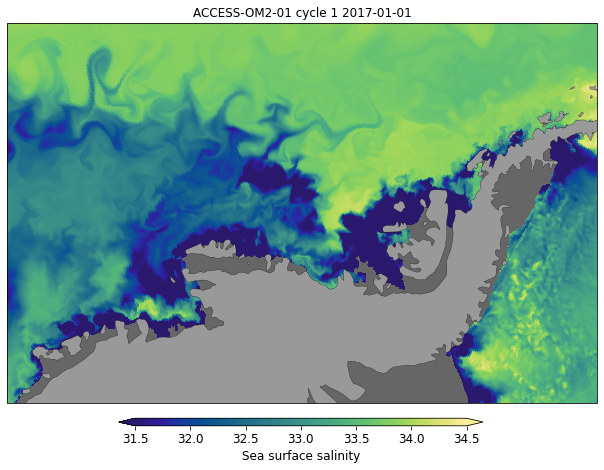

In [133]:
# plot daily SSS from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    for ekey in list(ice_data.keys())[2:]:
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['sss']:
                for date in ide[var]['time'].data:
                    datestr = date.strftime('%Y-%m-%d')
                    if datestr[0:7] == '2017-01':
                        title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                        fname = figname('_'.join([viewname, var, 
                                                  ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                                  datestr]))
                        if os.path.exists(fname):
                            print('   -- skipping', fname)
                        else:
                            v = ide[var].sel(time=date)
                            print('doing', fname)
                            plotSIC(v, cbar_label='Sea surface salinity', cmp=cm.cm.haline,
                                cmap_gamma=1.0, cbar_ticklevels=np.arange(31.5, 34.501, 0.5), cbar_sigfigs=2, extend='both', **view).set_title(title);
                            savefigure(fname)
                            plt.close()
#                             break
            break  # only do cycle 1
print('done')

In [175]:
# plot daily SST from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    for ekey in list(ice_data.keys())[2:]:
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['sst']:
                for date in ide[var]['time'].data:
                    datestr = date.strftime('%Y-%m-%d')
                    if datestr[0:7] == '2017-01':
                        title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                        fname = figname('_'.join([viewname, var, 
                                                  ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                                  datestr]))
                        if False: #os.path.exists(fname):
                            print('   -- skipping', fname)
                        else:
                            v = ide[var].sel(time=date) - 273.15
                            print('doing', fname)
                            plotSIC(v, cbar_label='Sea surface temperature (°C)', cmp=cm.cm.thermal,
                                cmap_gamma=1.0, cbar_ticklevels=np.arange(-2, 7, 1), cbar_sigfigs=1, extend='max', **view).set_title(title);
                            savefigure(fname)
                            plt.close()
#                             break
            break  # only do cycle 1
print('done')

Amundsen-Bellingshausen
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-01_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-02_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-03_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-04_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-05_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-06_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-07_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-08_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-09_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-10_200dpi.png
doing figs/Amundsen-Bellingshausen_sst_01deg_jra55v140_iaf_cycle1_2017-01-11_200dpi.png
doing fi

## JRA55 monthly climatology

In [59]:
# plot monthly climatological JRA siconc and siconca
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for var in ['siconc_mm', 'siconca_mm']:
        for m in range(1,13):
            title = ' '.join(['JRA55-do', var, yearrange, calendar.month_name[m], 'mean'])
            fname = figname('_'.join([viewname, var, 
                                      yearrange, 'mean', 'month', str(m).zfill(2)]))
            if os.path.exists(fname):
                print('   -- skipping', fname)
            else:
                print('doing', fname)
                v = JRA_data[var].sel(month=m)/100
                siconc = JRA_data['siconc_mm'].sel(month=m)/100
                siconca = JRA_data['siconca_mm'].sel(month=m)/100
                obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                plotSIC(v, cbar_label='Sea ice concentration',
                    contourvars=[
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                    (siconc.isel(longitude=slice(0, 158)), 'siconc', {'levels': extlevel, 'colors': 'g'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (siconc.isel(longitude=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'g'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (siconca.isel(longitude=slice(0, 158)), 'siconca', {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (siconca.isel(longitude=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'r'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (obsv.isel(xt_ocean=slice(0, 158)), 'NSIDC', {'levels': extlevel, 'colors': 'silver'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'silver'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    ], **view).set_title(title);
                savefigure(fname)
                plt.close()

#             break
#         break
print('done')

SH
doing figs/SH_siconc_mm_1993-2017_mean_month_01_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_02_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_03_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_04_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_05_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_06_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_07_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_08_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_09_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_10_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_11_200dpi.png
doing figs/SH_siconc_mm_1993-2017_mean_month_12_200dpi.png
doing figs/SH_siconca_mm_1993-2017_mean_month_01_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_02_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_03_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_04_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_05_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_06_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_07_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_08_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_09_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_10_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_11_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm_1993-2017_mean_month_12_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


done


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [63]:
# plot monthly climatological JRA siconc and siconca bias relative to NSIDC
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    for var in ['siconc_mm', 'siconca_mm']: 
        for m in range(1,13):
            title = ' '.join(['JRA55-do', var, yearrange, calendar.month_name[m], 'bias'])
            fname = figname('_'.join([viewname, var+'-obs', 
                                      yearrange, 'mean', 'month', str(m).zfill(2)]))
            if os.path.exists(fname):
                print('   -- skipping', fname)
            else:
                print('doing', fname)
                siconc = JRA_data['siconc_mm'].sel(month=m)/100
                siconca = JRA_data['siconca_mm'].sel(month=m)/100
                obsv = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
                v = JRA_data[var + '_regridded_to_'+hem+'obs'].sel(month=m) - obsv
                plotSIC(v, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus NSIDC',
                    cmap_gamma=1., cbar_ticklevels=np.arange(-.15,.1501,.05), cbar_sigfigs=2,
                    contourvars=[
# sliced to work around a cartopy bug https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
                    (siconc.isel(longitude=slice(0, 158)), 'siconc', {'levels': extlevel, 'colors': 'g'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (siconc.isel(longitude=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'g'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (siconca.isel(longitude=slice(0, 158)), 'siconca', {'levels': extlevel, 'colors': 'y'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (siconca.isel(longitude=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'y'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    (obsv.isel(xt_ocean=slice(0, 158)), 'NSIDC', {'levels': extlevel, 'colors': 'silver'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()}),
                    (obsv.isel(xt_ocean=slice(158, 100000)), None, {'levels': extlevel, 'colors': 'silver'}), #, 'x': 'longitude', 'y': 'latitude', 'transform': ccrs.PlateCarree()})],
                    ], 
                        **view).set_title(title);
                savefigure(fname)
                plt.close()

#             break
#         break
print('done')

SH
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_01_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


doing figs/SH_siconc_mm-obs_1993-2017_mean_month_02_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


doing figs/SH_siconc_mm-obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_05_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_06_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_07_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_08_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_09_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_10_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_11_200dpi.png
doing figs/SH_siconc_mm-obs_1993-2017_mean_month_12_200dpi.png
doing figs/SH_siconca_mm-obs_1993-2017_mean_month_01_200dpi.png
doing figs/SH_siconca_mm-obs_1993-2017_mean_month_02_200dpi.png
doing figs/SH_siconca_mm-obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_siconca_mm-obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_siconca_mm-obs_1993-2017_mean_month_05_200dpi.png
doing figs/SH_siconca_mm-obs_1993-2017_mean_month_

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm-obs_1993-2017_mean_month_10_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm-obs_1993-2017_mean_month_11_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


doing figs/SH_siconca_mm-obs_1993-2017_mean_month_12_200dpi.png


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


done


## JRA55 daily means

No handles with labels found to put in legend.


SH
doing figs/SH_siconc_JRA55-do_2017-01-01_200dpi.png
done


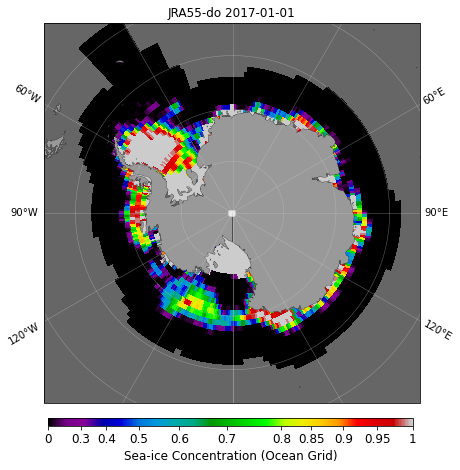

In [27]:
# plot daily JRA siconc
for viewname, view in views.items():
    print(viewname)
    for var in ['siconc']:
        for date in JRA_data[var]['time'].data:
            datestr = np.datetime_as_string(date, unit='D')
            if datestr[0:7] == '2017-01':
                title = ' '.join(['JRA55-do', datestr])
                fname = figname('_'.join([viewname, var, 'JRA55-do', datestr]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = JRA_data[var].sel(time=date)/100
                    print('doing', fname)
                    plotSIC(v, cbar_label=JRA_data[var].long_name.replace('Area Percentage', 'Concentration'), **view).set_title(title);
#                     savefigure(fname)
#                     plt.close()
                    break
print('done')

In [139]:
# plot daily JRA uas, vas
for viewname, view in views.items():
    print(viewname)
    for var in ['uas_d']:
        for date in JRA_data[var]['time'].data:
            datestr = np.datetime_as_string(date, unit='D')
            if datestr[0:7] == '2017-01':
                title = ' '.join(['JRA55-do', datestr])
                fname = figname('_'.join([viewname, var, 'JRA55-do', datestr]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = JRA_data[var].sel(time=date)
                    print('doing', fname)
                    plotSIC(v, cbar_label=JRA_data[var].long_name+' (m/s)', cmp=plt.get_cmap('seismic'),
                        cmap_gamma=1.0, cbar_ticklevels=np.arange(-15, 15.001, 5), cbar_sigfigs=0, extend='both', **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#                     break
print('done')

Amundsen-BellingshausenSP
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-01_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-02_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-03_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-04_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-05_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-06_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-07_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-08_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-09_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-10_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-11_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-12_200dpi.png
doing figs/Amundsen-BellingshausenSP_uas_d_JRA55-do_2017-01-13_200dpi.png
doing figs/A

In [136]:
# plot daily JRA 'psl'
for viewname, view in views.items():
    print(viewname)
    for var in ['psl_d']:
        for date in JRA_data[var]['time'].data:
            datestr = np.datetime_as_string(date, unit='D')
            if datestr[0:7] == '2017-01':
                title = ' '.join(['JRA55-do', datestr])
                fname = figname('_'.join([viewname, var, 'JRA55-do', datestr]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = JRA_data[var].sel(time=date)/100 # convert to hPa
                    print('doing', fname)
                    plotSIC(v, cbar_label=JRA_data[var].long_name+' (hPa)', cmp=cm.cm.thermal,
                        cmap_gamma=1.0, cbar_ticklevels=np.arange(960, 1021, 20), cbar_sigfigs=0, extend='both', **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#                     break
print('done')

Amundsen-BellingshausenSP
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-01_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-02_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-03_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-04_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-05_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-06_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-07_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-08_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-09_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-10_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-11_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-12_200dpi.png
doing figs/Amundsen-BellingshausenSP_psl_d_JRA55-do_2017-01-13_200dpi.png
doing figs/A

In [134]:
# plot daily JRA 'tas'
for viewname, view in views.items():
    print(viewname)
    for var in ['tas_d']:
        for date in JRA_data[var]['time'].data:
            datestr = np.datetime_as_string(date, unit='D')
            if datestr[0:7] == '2017-01':
                title = ' '.join(['JRA55-do', datestr])
                fname = figname('_'.join([viewname, var, 'JRA55-do', datestr]))
                if False: #os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = JRA_data[var].sel(time=date) - 273.15  # convert to C
                    print('doing', fname)
                    plotSIC(v, cbar_label=JRA_data[var].long_name+' (°C)', cmp=cm.cm.thermal,
                        cmap_gamma=1.0, cbar_ticklevels=np.arange(-8, 3.001, 1), cbar_sigfigs=0, extend='both', **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#                     break
print('done')

Amundsen-BellingshausenSP
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-01_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-02_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-03_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-04_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-05_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-06_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-07_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-08_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-09_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-10_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-11_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-12_200dpi.png
doing figs/Amundsen-BellingshausenSP_tas_d_JRA55-do_2017-01-13_200dpi.png
doing figs/A

In [132]:
# plot daily JRA 'rlds'
for viewname, view in views.items():
    print(viewname)
    for var in ['rlds_d']:
        for date in JRA_data[var]['time'].data:
            datestr = np.datetime_as_string(date, unit='D')
            if datestr[0:7] == '2017-01':
                title = ' '.join(['JRA55-do', datestr])
                fname = figname('_'.join([viewname, var, 'JRA55-do', datestr]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = JRA_data[var].sel(time=date)
                    print('doing', fname)
                    plotSIC(v, cbar_label=JRA_data[var].long_name+' ('+JRA_data[var].units+')', cmp=cm.cm.thermal,
                        cmap_gamma=1.0, cbar_ticklevels=np.arange(150, 401, 50), cbar_sigfigs=0, extend='both', **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#                     break
print('done')

Amundsen-BellingshausenSP
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-01_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-02_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-03_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-04_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-05_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-06_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-07_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-08_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-09_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-10_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-11_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-12_200dpi.png
doing figs/Amundsen-BellingshausenSP_rlds_d_JRA55-do_2017-01-13_200dpi.png

In [131]:
# plot daily JRA 'rsds'
for viewname, view in views.items():
    print(viewname)
    for var in ['rsds_d']:
        for date in JRA_data[var]['time'].data:
            datestr = np.datetime_as_string(date, unit='D')
            if datestr[0:7] == '2017-01':
                title = ' '.join(['JRA55-do', datestr])
                fname = figname('_'.join([viewname, var, 'JRA55-do', datestr]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
                    v = JRA_data[var].sel(time=date)
                    print('doing', fname)
                    plotSIC(v, cbar_label=JRA_data[var].long_name+' ('+JRA_data[var].units+')', cmp=cm.cm.thermal,
                        cmap_gamma=1.0, cbar_ticklevels=np.arange(0, 401, 50), cbar_sigfigs=0, extend='max', **view).set_title(title);
                    savefigure(fname)
                    plt.close()
#                     break
print('done')

Amundsen-BellingshausenSP
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-01_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-02_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-03_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-04_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-05_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-06_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-07_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-08_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-09_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-10_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-11_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-12_200dpi.png
doing figs/Amundsen-BellingshausenSP_rsds_d_JRA55-do_2017-01-13_200dpi.png

## Misc

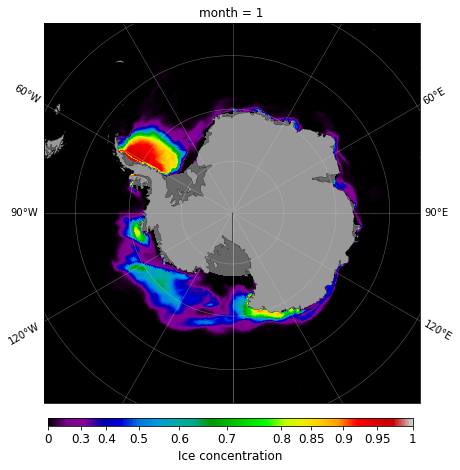

In [53]:
plotSIC(v, **SH);

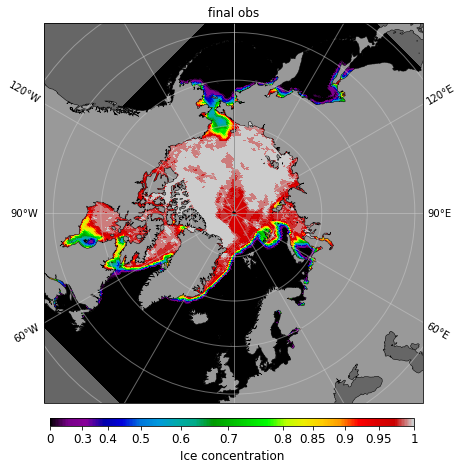

In [22]:
plotSIC(obs_NH.isel(time=-1), **NH).set_title('final obs');

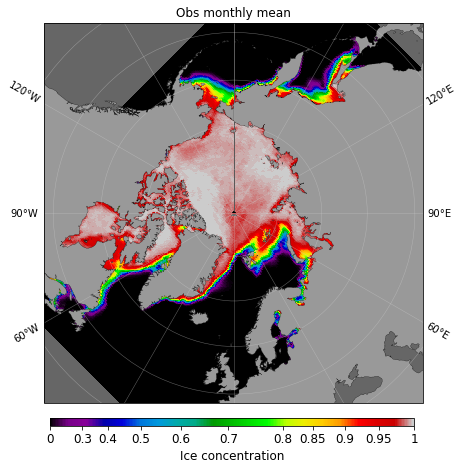

In [25]:
plotSIC(obs_NH_mm.sel(month=1), **NH).set_title('Obs monthly mean');

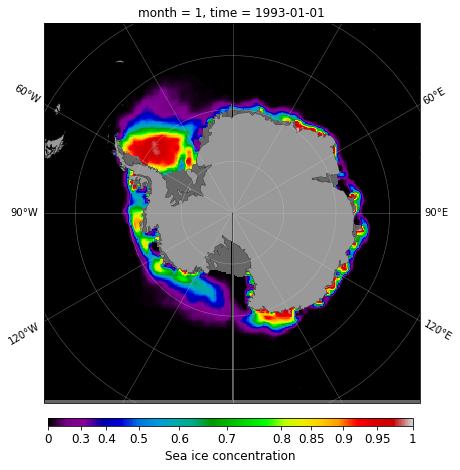

In [27]:
plotSIC(obs_SH_mm.sel(month=1), **SH);

# SIC histogram vs. obs
TODO: 
- weight count by area?
- normalise by obs count?

In [48]:
for viewname, view in views.items():
    print(viewname)
    for ekey in ensemble:
        if viewname in ['NH']:
            hem = 'NH'
        else:
            hem = 'SH'
        obsv = eval('_'.join(['obs', hem]))
        vref = obsregridders[hem][ice_data[ekey][0]['res']](obsv)
        vref = vref.isel(time=slice(0, -1))            
#         vref.time.data = ice_data[ekey][0]['aice_m'].time.data
        # obs dates are first day of month but cice dates are last day of month
        # so align vref to use same dates as cice
#         vref, _ = xr.align(vref, ice_data[ekey][0]['aice_m'], join='right')
#         vref_m = vref.groupby('time.month')
    #     break
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            v = ide['aice_m']
            if hem == 'NH':
                v = v.where(v.yt_ocean>0)
            else:
                v = v.where(v.yt_ocean<0)
#             bias = v - vref
#             bias_m = bias.groupby('time.month')
            for m in range(1, 13):
    #             v = ide[var]
    #             vref = vrefs.sel(month=m)
                title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'bias'])
                fname = figname('_'.join([viewname, 'aice_m', 
                                          ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycm2+1
                                          'hist_vs_obs',
                                          yearrange, 'month', str(m).zfill(2)]))
                if os.path.exists(fname):
                    print('   -- skipping', fname)
                else:
    #                     v = ide[var].sel(month=m)
    #                     bias = v - vref
                    print('doing', fname)
#                     plt.scatter(vref_m.sel(month=m), bias_m.sel(month=m))
                    vrefm = vref.sel(time=(vref['time.month']==m)).data.ravel()
                    vm = v.sel(time=(v['time.month']==m)).data.ravel()
                    fig, ax = plt.subplots(nrows=1, ncols=1)
                    ax.set_facecolor('k')
#                     fig = plt.figure() #(figsize=(7,7))
#                     fig.patch.set_facecolor('black')

#                     plt.scatter(vrefm, vm-vrefm, s=.1)
#                     plt.hist2d(vref.isel(time=8).data.ravel(), 
#                       v.where(v.yt_ocean<0).isel(time=8).data.ravel(),
#                       bins=100, range=[[0, 1], [0, 1]], norm=colors.LogNorm(),
#                       cmap=plt.cm.get_cmap('nipy_spectral_r'));
                    plt.hist2d(vrefm, vm,
                      bins=100, range=[[0, 1], [0, 1]], 
                      norm=colors.LogNorm(), 
                    # TODO: pick cmax value automatically
                      cmax=1e5,  # cmax=1e5 for 1deg, 1e6 for 0.25deg, 
#                       cmap=cm.cm.ice)
                      cmap=plt.cm.get_cmap('hot'))
#                       cmap=plt.cm.get_cmap('nipy_spectral'))
                    plt.plot([0, 1],[0, 1], 'g', linewidth=2)
                    plt.colorbar()
                    plt.title(title)
                    plt.xlabel('NSIDC passive microwave SIC')
                    plt.ylabel('Model SIC')
                    savefigure(fname)
                    plt.close()
#                     break
#             break
#         break


print('done')

SH
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_01_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_02_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_03_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_04_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_05_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_06_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_07_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_08_200dpi.png
doing figs/SH_aice_m_025deg_jra55_iaf_ensemble_albicev_0.9_cycle1_hist_vs_obs_1993-2017_month_09_200dpi.png
doing figs/SH_aice_m_025d

In [125]:
# histograms for GIOMAS SIC
GIOMAS_aice_m_regridded = regrid_giomas_to_025(GIOMAS['aice_m'])
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    obsv = eval('_'.join(['obs', hem]))
    vref = eval('regrid_'+hem+'obs_to_025(obsv)')
    vref = vref.isel(time=slice(0, -1))            
#         vref.time.data = ice_data[ekey][0]['aice_m'].time.data
    # obs dates are first day of month but cice dates are last day of month
    # so align vref to use same dates as cice
#         vref, _ = xr.align(vref, ice_data[ekey][0]['aice_m'], join='right')
#         vref_m = vref.groupby('time.month')
#     break
#         for cycle, ide in enumerate(ice_data[ekey], start=1):
    v = GIOMAS_aice_m_regridded
    if hem == 'NH':
        v = v.where(v.yt_ocean>0)
    else:
        v = v.where(v.yt_ocean<0)
    for m in range(1, 13):
        title = ' '.join(['GIOMAS', yearrange, calendar.month_name[m], 'bias'])
        fname = figname('_'.join([viewname, 'aice_m', 
                                  'GIOMAS',
                                  'hist_vs_obs',
                                  yearrange, 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            print('doing', fname)
            vrefm = vref.sel(time=(vref['time.month']==m)).data.ravel()
            vm = v.sel(time=(v['time.month']==m)).data.ravel()
            fig, ax = plt.subplots(nrows=1, ncols=1)
            ax.set_facecolor('k')
#                     fig = plt.figure() #(figsize=(7,7))
#                     fig.patch.set_facecolor('black')

#                     plt.scatter(vrefm, vm-vrefm, s=.1)
#                     plt.hist2d(vref.isel(time=8).data.ravel(), 
#                       v.where(v.yt_ocean<0).isel(time=8).data.ravel(),
#                       bins=100, range=[[0, 1], [0, 1]], norm=colors.LogNorm(),
#                       cmap=plt.cm.get_cmap('nipy_spectral_r'));
            plt.hist2d(vrefm, vm,
              bins=100, range=[[0, 1], [0, 1]], 
              norm=colors.LogNorm(), 
            # TODO: pick cmax value automatically
              cmax=1e5,  # cmax=1e5 for 1deg, 1e6 for 0.25deg, 
#                       cmap=cm.cm.ice)
              cmap=plt.cm.get_cmap('hot'))
#                       cmap=plt.cm.get_cmap('nipy_spectral'))
            plt.plot([0, 1],[0, 1], 'g', linewidth=2)
            plt.colorbar()
            plt.title(title)
            plt.xlabel('NSIDC passive microwave SIC')
            plt.ylabel('GIOMAS SIC')
            savefigure(fname)
            plt.close()
#             break
#         break
#     break

print('done')

SH
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_01_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_02_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_03_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_04_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_05_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_06_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_07_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_08_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_09_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_10_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_11_200dpi.png
doing figs/SH_aice_m_GIOMAS_hist_vs_obs_1993-2017_month_12_200dpi.png
done


# Timeseries plots

## Time series of sea ice volume (by category), area, extent and snow volume

`vicen_m(time, nc, nj, ni)`
		has units = "m",
so need to multiply by `area_t` to get volume.
`nc` is number of ice categories.

We use kcatbound=0, so lower bound of ice categories is 0, 0.64, 1.39, 2.47, 4.57m (HunkeLipscombTurnerJefferyElliott2015a-CICE5p1, table 2).

Much of the Arctic ice volume (not area) is >4.57m thick, including in the summer minimum.

<font color="FF0000"><B>FIXME:<B> land mask area differs between the three configurations and differs from obs, especially in the Canadian Archipelago and River Ob - how to remove this bias in the total extent, area and volume? Can we at least quantify the area differences poleward of (say) 65N/S?
</font>

In [23]:
initial_transient = False

In [24]:
def calcvol(ide, timerange=timerange):
# WARNING - this can take several minutes
    loaddata(ide, varnames=['hi_m', 'area_t'], timerange=timerange)
    if 'NH_ice_volume' not in ide.keys():
        volume = ide['hi_m']*ide['area_t'] # hi_m(time, nc, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
        volume_zonalsum = volume.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_ice_volume'] = volume_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_ice_volume'] = volume_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')

In [25]:
def calcvolcat(ide, timerange=timerange):
# WARNING - this can take several minutes
    loaddata(ide, varnames=['vicen_m', 'area_t'], timerange=timerange)
    if 'NH_ice_volume_cat' not in ide.keys():
        volume = ide['vicen_m']*ide['area_t'] # vicen_m(time, nc, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
        volume_zonalsum = volume.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_ice_volume_cat'] = volume_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_ice_volume_cat'] = volume_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')

In [26]:
def plotvol(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+str(c+1))
#         if not initial_transient:
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
             color='C'+str(c), linewidth=2)
#     total
#     plt.plot(v['time'],v.sum(axis=-1)/1e12, color='k', linewidth=1, label='Total')
#     plt.plot(v['time'][6:-5],
#              v.rolling(time=12, center=True).mean().sum(axis=-1)[6:-5]/1e12,  # 12-month rolling mean
#              color='k', linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)')

In [27]:
def plotvolcumul(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, linewidth=1)
#         if not initial_transient:
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)')

In [28]:
def plotvolcatcumul(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    v = v.cumsum(axis=-1)
    cats = list(range(len(v['nc'])))
    cats.reverse()  # so legend is in same order as plotted data
    for c in cats:
        plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+'+'.join([str(f+1) for f in range(c+1)]))
#         if not initial_transient:
        plt.plot(v['time'],
                 v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
                 color='C'+str(c), linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)')

## Seasonal cycle of sea ice extent and area
We adopt the usual definition of sea ice extent as the area in which sea ice concentration exceeds 15\%.

- obs in `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/north/monthly/data/*.csv` and  `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/south/monthly/data/*.csv`
- file names `N_mm_extent_v3.0.csv`, `S_mm_extent_v3.0.csv` where `mm` is month number
- first full year: 1979
- last full year: 2017
- missing extent data (-9999): Dec 1987, Jan 1988

CSV format:
```
year, mo,    data-type, region, extent,   area
1978, 12,      Goddard,      N,  13.67,  10.90
...
```


In [29]:
def loadObsExt(fnlist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list
    """
    df = pd.concat([pd.read_csv(f) for f in fnlist])  # read all csv files into a pandas DataFrame
    df.columns = df.columns.str.strip()  # remove leading/trailing whitespace from headers
#     df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
    df['time'] = df.apply(lambda r: cftime.DatetimeGregorian(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
#     print(df)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  # remove redundant columns
    num = df._get_numeric_data()
    num[num < 0] = np.nan  # replace bad data with NaN
    df = df.sort_values('time')
    ds = df.to_xarray()  # convert to xarray DataSet
    ds = ds.assign_coords(index=ds['time']).drop('time')  # set index values to time and remove time
    ds['extent'] = ds.extent.rename({'index': 'time'})  # rename extent coord to time
    ds['area'] = ds.area.rename({'index': 'time'})  # rename area coord to time
    ds = ds.drop('index')  # remove index
    ds = ds*1e12  # convert from M km^2 to m^2
    return ds

In [30]:
obs_ext_NH = loadObsExt(obsExtNHFileList)
obs_ext_NH_mm = obs_ext_NH.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
obs_ext_SH = loadObsExt(obsExtSHFileList)
obs_ext_SH_mm = obs_ext_SH.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [31]:
def calcarea(ide, timerange=timerange):
    loaddata(ide, varnames=['aice_m', 'area_t'], timerange=timerange)
    if 'NH_area' not in ide.keys():
        area = ide['aice_m']*ide['area_t']
        area_zonalsum = area.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_area'] = area_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_area'] = area_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
        ide['NH_area_clim'] = ide['NH_area'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
        ide['SH_area_clim'] = ide['SH_area'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [32]:
def calcextent(ide, timerange=timerange):
    loaddata(ide, varnames=['aice_m', 'area_t'], timerange=timerange)
    if 'NH_extent' not in ide.keys():
        extent = xr.where(ide['aice_m'] > 0.15, ide['area_t'], 0)
        extent_zonalsum = extent.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_extent'] = extent_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_extent'] = extent_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
        ide['NH_extent_clim'] = ide['NH_extent'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
        ide['SH_extent_clim'] = ide['SH_extent'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [33]:
def plotarea(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice area (10$^{12}$ m$^2$)',font)

In [34]:
def plotareaNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotarea(NH_area, obs_ext_NH.area)
    plt.title('Arctic ice area, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotarea(SH_area, obs_ext_SH.area)
    plt.title('Antarctic ice area, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_area_'+ekey)

In [35]:
def plotextent(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice extent (10$^{12}$ m$^2$)',font)

In [36]:
def plotextentNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(1,2,1)
    plotextent(NH_extent, obs_ext_NH.extent)
    plt.title('Arctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(1,2,2)
    plotextent(SH_extent, obs_ext_SH.extent)
    plt.title('Antarctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_extent_'+ekey)

In [37]:
# for ekey in ice_data.keys():
for ekey in ensemble:
    print(ekey)
    for ide in ice_data[ekey]:
#         calcvol(ide)
        calcarea(ide)
#         calcextent(ide)
#         break  # only load cycle 1
#     break

025deg_albicev_0.9
025deg_control
1deg_albicev_0.78
1deg_albicev_0.81
1deg_albicev_0.9
1deg_control


## 12-mo running mean min, mean and max

In [38]:
ice_data[controlkeys[0]][0]['params']

{'albicei': 0.44,
 'albicev': 0.86,
 'turning_angle': 0.0,
 'dragio': 0.00536,
 'mu_rdg': 3,
 'aice_cutoff': 0.15,
 'snowpatch': 0.02,
 'chio': 0.006,
 'ndte': 120,
 'j09_bgmax': 5e-06}

In [39]:
all_keys = set().union(*(ice_data[k][0]['params'].keys() for k in controlkeys))
all_keys

{'aice_cutoff',
 'albicei',
 'albicev',
 'chio',
 'dragio',
 'j09_bgmax',
 'mu_rdg',
 'ndte',
 'snowpatch',
 'turning_angle'}

In [59]:
# https://stackoverflow.com/questions/65806135/overflowerror-fig-savefig-triggered-by-dpi
matplotlib.use('Agg')
matplotlib.rcParams['agg.path.chunksize'] = 200


In [57]:
matplotlib.style.use('fast')


In [54]:
allparams

{'aice_cutoff',
 'albicei',
 'albicev',
 'chio',
 'dragio',
 'j09_bgmax',
 'mu_rdg',
 'ndte',
 'snowpatch',
 'turning_angle'}

In [61]:
# 12-mo running mean minimum, mean and maximum of area -- separate plots for each perturbed parameter

def running(op, v):
    return eval("v['time'][6:-5],v.rolling(time=12, center=True)."+op+"()[6:-5]")

# cols = plt.get_cmap('nipy_spectral')
# cols = plt.get_cmap('hsv')
cols = plt.get_cmap('plasma')
# cols = cm.cm.thermal
linestyles = ['-', '--', ':', '-.']
lwidth = 0.5

allparams = set().union(*(ice_data[k][0]['params'].keys() for k in controlkeys))
allparams = ['albicev']

for cycle in range(1, 2):
    for param in allparams:  # NB: assumes the same params at both resolutions!
        subensemble = [ k for k in ensemble if ice_data[k][0]['perturbed']==param or (ice_data[k][0]['perturbed']==None and param in ice_data[k][0]['params']) ]
        print(subensemble)
        vals = [ ice_data[k][0]['params'][param] for k in subensemble ] #if param in ice_data[k][0]['params'] ]
        # sort vals and subensemble by value
        vs = sorted(zip(vals, subensemble))
        vals = [ v for v, _ in vs ]
        subensemble = [ s for _, s in vs ]
        labels = [ param+'='+str(v) for v in vals ]
        for controlkey in controlkeys:
            try:                                                                ## KLUDGE! shouldn't need this
                labels[subensemble.index(controlkey)] += ' (control)'
            except:
                pass
        if len(subensemble) > 1:
            colsteps = min(20, len(subensemble))
            lsstep = colsteps
            plt.figure(1,(12,5))                                                                                               
            for c, k in enumerate(subensemble):               
                ide = ice_data[k][cycle-1]
                cval = ((c)/colsteps)%1
                if k.split('_')[0] == '1deg':
                    label = labels[c]+', 1°'
                    linestyle = '-'
                else:
                    label = labels[c]+', 0.25°'
                    linestyle = '--'
#                 linestyle = linestyles[(c//lsstep) % len(linestyles)]
                lw = lwidth
                if k in controlkeys:
                    lw *= 3
                plt.subplot(1,2,1)
                v = ide['NH_area']/1e12
                plt.plot(*running('max', v), color=cols(cval), linewidth=lw, linestyle=linestyle, label=label)
                plt.plot(*running('mean', v), color=cols(cval), linewidth=lw, linestyle=linestyle)
                plt.plot(*running('min', v), color=cols(cval), linewidth=lw, linestyle=linestyle)

                plt.subplot(1,2,2)
                v = ide['SH_area']/1e12
                plt.plot(*running('max', v), color=cols(cval), linewidth=lw, linestyle=linestyle, label=label)
                plt.plot(*running('mean', v), color=cols(cval), linewidth=lw, linestyle=linestyle)
                plt.plot(*running('min', v), color=cols(cval), linewidth=lw, linestyle=linestyle)

            plt.subplot(1,2,1)
            v = obs_ext_NH.area/1e12
            plt.plot(*running('max', v), color='k', linewidth=2*lwidth, label='Observations')
            plt.plot(*running('mean', v), color='k', linewidth=2*lwidth)
            plt.plot(*running('min', v), color='k', linewidth=2*lwidth)

            plt.subplot(1,2,2)
            v = obs_ext_SH.area/1e12
            plt.plot(*running('max', v), color='k', linewidth=2*lwidth, label='Observations')
            plt.plot(*running('mean', v), color='k', linewidth=2*lwidth)
            plt.plot(*running('min', v), color='k', linewidth=2*lwidth)

            plt.subplot(1,2,1)
            plt.ylim(ymin=0,ymax=22)
            plt.grid(axis='y')
            plt.xlabel('Year')
            plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
        #     plt.title('Arctic ice area min, mean and max, cycle ' + str(cycle))
            plt.title('Arctic ice area min, mean and max')
            plt.subplot(1,2,2)
            plt.ylim(ymin=0,ymax=22)
            plt.grid(axis='y')
            plt.xlabel('Year')
        #     plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
        #     plt.title('Antarctic ice area min, mean and max, cycle ' + str(cycle))
            plt.title('Antarctic ice area min, mean and max')
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=-(-len(subensemble)//25))

#             plt.tight_layout()

        #     fname = os.path.join('figs', 'ice_area_min_mean_max_all_cycle'+str(cycle)+'.pdf')
            fname = os.path.join('figs', 'ice_area_min_mean_max_'+param+'.pdf')
            fname = os.path.join('figs', 'ice_area_min_mean_max_'+param+'_new.pdf')

            fname = os.path.join('figs', 'ice_area_min_mean_max_'+param+'_new.png')

            if os.path.exists(fname):
                print('   -- skipping', fname)
#                 break
            else:
#                     v = ide[var].sel(month=m)
#                     bias = v - vref
                print('saving', fname)
#                 plt.savefig(fname, bbox_inches='tight')
#                 plt.close()
            break

['025deg_albicev_0.9', '025deg_control', '1deg_albicev_0.78', '1deg_albicev_0.81', '1deg_albicev_0.9', '1deg_control']
saving figs/ice_area_min_mean_max_albicev_new.png
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x148ebff23b80> (for post_execute):


OverflowError: time values outside range of 64 bit signed integers

OverflowError: time values outside range of 64 bit signed integers

<Figure size 1200x500 with 2 Axes>

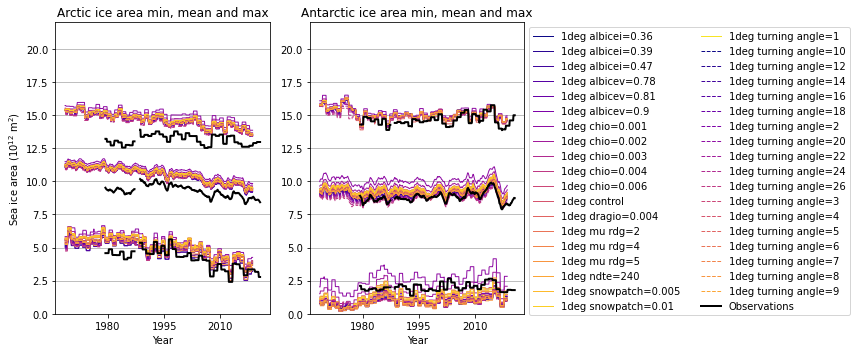

In [42]:
# 12-mo running mean minimum, mean and maximum of area for all models

# TODO: different colour for each perturbation variable, then different line pattern for perturbation values


def running(op, v):
    return eval("v['time'][6:-5],v.rolling(time=12, center=True)."+op+"()[6:-5]")


cols = plt.get_cmap('nipy_spectral')
cols = plt.get_cmap('hsv')

cols = plt.get_cmap('plasma')

# cols = cm.cm.thermal
colsteps = min(20, len(ensemble))
linestyles = ['-', '--', ':', '-.']
lsstep = colsteps
lwidth = 1
for cycle in range(1, 2):
    plt.figure(1,(12,5))
    for c, k in enumerate(ensemble):
        ide = ice_data[k][cycle-1]
        cval = ((c)/colsteps)%1
        linestyle = linestyles[(c//lsstep) % len(linestyles)]
        plt.subplot(1,2,1)
        v = ide['NH_area']/1e12
        plt.plot(*running('max', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle, label=ide['desc'])
        plt.plot(*running('mean', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)
        plt.plot(*running('min', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)

        plt.subplot(1,2,2)
        v = ide['SH_area']/1e12
        plt.plot(*running('max', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle, label=ide['desc'])
        plt.plot(*running('mean', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)
        plt.plot(*running('min', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)

    plt.subplot(1,2,1)
    v = obs_ext_NH.area/1e12
    plt.plot(*running('max', v), color='k', linewidth=2*lwidth, label='Observations')
    plt.plot(*running('mean', v), color='k', linewidth=2*lwidth)
    plt.plot(*running('min', v), color='k', linewidth=2*lwidth)

    plt.subplot(1,2,2)
    v = obs_ext_SH.area/1e12
    plt.plot(*running('max', v), color='k', linewidth=2*lwidth, label='Observations')
    plt.plot(*running('mean', v), color='k', linewidth=2*lwidth)
    plt.plot(*running('min', v), color='k', linewidth=2*lwidth)

    plt.subplot(1,2,1)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
#     plt.title('Arctic ice area min, mean and max, cycle ' + str(cycle))
    plt.title('Arctic ice area min, mean and max')
    plt.subplot(1,2,2)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
#     plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
#     plt.title('Antarctic ice area min, mean and max, cycle ' + str(cycle))
    plt.title('Antarctic ice area min, mean and max')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=-(-len(ensemble)//25))

    plt.tight_layout()
    
#     fname = os.path.join('figs', 'ice_area_min_mean_max_all_cycle'+str(cycle)+'.pdf')
    fname = 'ice_area_min_mean_max_param.pdf'

#     plt.savefig(fname, bbox_inches='tight')
#     plt.close()

In [55]:
v

<xarray.DataArray (time: 0)>
array([], dtype=float64)
Coordinates:
  * time     (time) object

In [84]:
ide['NH_area'] #- obs_ext_NH.area

<xarray.DataArray (time: 612)>
array([1.4411817e+13, 1.5405868e+13, 1.5724652e+13, 1.5036181e+13,
       1.3376432e+13, 1.0904110e+13, 8.4154222e+12, 6.2280040e+12,
       5.8277967e+12, 8.5111839e+12, 1.1029388e+13, 1.3092268e+13,
       1.4246483e+13, 1.5240034e+13, 1.5674772e+13, 1.5212536e+13,
       1.3589955e+13, 1.1336608e+13, 8.8764517e+12, 6.7980110e+12,
       6.5611288e+12, 8.6248883e+12, 1.0685217e+13, 1.2679811e+13,
       1.4217123e+13, 1.5439720e+13, 1.5659096e+13, 1.5123596e+13,
       1.3463947e+13, 1.0895063e+13, 8.5412702e+12, 6.4911431e+12,
       6.6082565e+12, 8.9645258e+12, 1.0672063e+13, 1.2807678e+13,
       1.4396706e+13, 1.5425807e+13, 1.5601685e+13, 1.5161302e+13,
       1.3670472e+13, 1.0964800e+13, 8.2752763e+12, 6.2077319e+12,
       5.7829910e+12, 8.3631245e+12, 1.0890991e+13, 1.2933443e+13,
       1.4547442e+13, 1.5730925e+13, 1.5953884e+13, 1.5298853e+13,
       1.3793753e+13, 1.1245686e+13, 8.7882717e+12, 6.6698278e+12,
       6.0119093e+12, 8.6407266e+12, 1.0988184e+13, 1.2835120e+13,
       1.4493597e+13, 1.5553192e+13, 1.5959939e+13, 1.5129120e+13,
       1.3452546e+13, 1.0671395e+13, 8.2182191e+12, 6.3041726e+12,
       6.3238906e+12, 8.8030472e+12, 1.0608353e+13, 1.2703939e+13,
       1.3952445e+13, 1.5159114e+13, 1.5235472e+13, 1.4905210e+13,
       1.3281091e+13, 1.0709019e+13, 8.2822782e+12, 6.2237290e+12,
...
       3.6463612e+12, 5.5565888e+12, 9.2698040e+12, 1.1632160e+13,
       1.3382079e+13, 1.4429193e+13, 1.4810541e+13, 1.4188408e+13,
       1.2339523e+13, 1.0177607e+13, 7.5435810e+12, 5.3375423e+12,
       4.6180703e+12, 6.7106961e+12, 9.7421686e+12, 1.1945356e+13,
       1.3251963e+13, 1.3984506e+13, 1.4473441e+13, 1.3845067e+13,
       1.2133241e+13, 1.0075973e+13, 7.3707448e+12, 5.3445709e+12,
       4.7017466e+12, 6.4455794e+12, 9.6785557e+12, 1.1893052e+13,
       1.3312962e+13, 1.4182007e+13, 1.4171565e+13, 1.3657605e+13,
       1.2227318e+13, 1.0020289e+13, 7.5808983e+12, 5.2803073e+12,
       4.6322827e+12, 6.3406515e+12, 9.6113263e+12, 1.1856377e+13,
       1.3218328e+13, 1.4104970e+13, 1.4475282e+13, 1.3901556e+13,
       1.1852460e+13, 9.4207266e+12, 6.6560454e+12, 4.4231248e+12,
       3.7485441e+12, 5.5479600e+12, 8.2356659e+12, 1.1095002e+13,
       1.2952947e+13, 1.4011907e+13, 1.4210319e+13, 1.3854974e+13,
       1.2308800e+13, 9.9357766e+12, 7.2607523e+12, 4.8716359e+12,
       4.1578786e+12, 6.1146105e+12, 8.9585877e+12, 1.1262310e+13,
       1.2737389e+13, 1.3462319e+13, 1.3857935e+13, 1.3482794e+13,
       1.1898180e+13, 9.8735091e+12, 7.3665038e+12, 4.9656276e+12,
       4.2584635e+12, 5.2088228e+12, 9.3226428e+12, 1.1598038e+13],
      dtype=float32)
Coordinates:
  * time     (time) object 1968-01-31 12:00:00 ... 2018-12-31 12:00:00

In [39]:
obs_ext_NH

<xarray.Dataset>
Dimensions:  (time: 507)
Coordinates:
  * time     (time) object 1978-11-01 00:00:00 ... 2021-01-01 00:00:00
Data variables:
    extent   (time) float64 1.165e+13 1.367e+13 ... 1.177e+13 1.348e+13
    area     (time) float64 9.04e+12 1.09e+13 1.241e+13 ... 1.013e+13 1.171e+13

In [58]:
da

<xarray.DataArray (time: 612)>
array([1.4411817e+13, 1.5405868e+13, 1.5724652e+13, 1.5036181e+13,
       1.3376432e+13, 1.0904110e+13, 8.4154222e+12, 6.2280040e+12,
       5.8277967e+12, 8.5111839e+12, 1.1029388e+13, 1.3092268e+13,
       1.4246483e+13, 1.5240034e+13, 1.5674772e+13, 1.5212536e+13,
       1.3589955e+13, 1.1336608e+13, 8.8764517e+12, 6.7980110e+12,
       6.5611288e+12, 8.6248883e+12, 1.0685217e+13, 1.2679811e+13,
       1.4217123e+13, 1.5439720e+13, 1.5659096e+13, 1.5123596e+13,
       1.3463947e+13, 1.0895063e+13, 8.5412702e+12, 6.4911431e+12,
       6.6082565e+12, 8.9645258e+12, 1.0672063e+13, 1.2807678e+13,
       1.4396706e+13, 1.5425807e+13, 1.5601685e+13, 1.5161302e+13,
       1.3670472e+13, 1.0964800e+13, 8.2752763e+12, 6.2077319e+12,
       5.7829910e+12, 8.3631245e+12, 1.0890991e+13, 1.2933443e+13,
       1.4547442e+13, 1.5730925e+13, 1.5953884e+13, 1.5298853e+13,
       1.3793753e+13, 1.1245686e+13, 8.7882717e+12, 6.6698278e+12,
       6.0119093e+12, 8.6407266e+12, 1.0988184e+13, 1.2835120e+13,
       1.4493597e+13, 1.5553192e+13, 1.5959939e+13, 1.5129120e+13,
       1.3452546e+13, 1.0671395e+13, 8.2182191e+12, 6.3041726e+12,
       6.3238906e+12, 8.8030472e+12, 1.0608353e+13, 1.2703939e+13,
       1.3952445e+13, 1.5159114e+13, 1.5235472e+13, 1.4905210e+13,
       1.3281091e+13, 1.0709019e+13, 8.2822782e+12, 6.2237290e+12,
...
       3.6463612e+12, 5.5565888e+12, 9.2698040e+12, 1.1632160e+13,
       1.3382079e+13, 1.4429193e+13, 1.4810541e+13, 1.4188408e+13,
       1.2339523e+13, 1.0177607e+13, 7.5435810e+12, 5.3375423e+12,
       4.6180703e+12, 6.7106961e+12, 9.7421686e+12, 1.1945356e+13,
       1.3251963e+13, 1.3984506e+13, 1.4473441e+13, 1.3845067e+13,
       1.2133241e+13, 1.0075973e+13, 7.3707448e+12, 5.3445709e+12,
       4.7017466e+12, 6.4455794e+12, 9.6785557e+12, 1.1893052e+13,
       1.3312962e+13, 1.4182007e+13, 1.4171565e+13, 1.3657605e+13,
       1.2227318e+13, 1.0020289e+13, 7.5808983e+12, 5.2803073e+12,
       4.6322827e+12, 6.3406515e+12, 9.6113263e+12, 1.1856377e+13,
       1.3218328e+13, 1.4104970e+13, 1.4475282e+13, 1.3901556e+13,
       1.1852460e+13, 9.4207266e+12, 6.6560454e+12, 4.4231248e+12,
       3.7485441e+12, 5.5479600e+12, 8.2356659e+12, 1.1095002e+13,
       1.2952947e+13, 1.4011907e+13, 1.4210319e+13, 1.3854974e+13,
       1.2308800e+13, 9.9357766e+12, 7.2607523e+12, 4.8716359e+12,
       4.1578786e+12, 6.1146105e+12, 8.9585877e+12, 1.1262310e+13,
       1.2737389e+13, 1.3462319e+13, 1.3857935e+13, 1.3482794e+13,
       1.1898180e+13, 9.8735091e+12, 7.3665038e+12, 4.9656276e+12,
       4.2584635e+12, 5.2088228e+12, 9.3226428e+12, 1.1598038e+13],
      dtype=float32)
Coordinates:
  * time     (time) object 1968-01-31 12:00:00 ... 2018-12-31 12:00:00

In [57]:
        da = ide['NH_area'].copy(deep=True)



In [59]:
ide['NH_area']

<xarray.DataArray (time: 612)>
array([1.4411817e+13, 1.5405868e+13, 1.5724652e+13, 1.5036181e+13,
       1.3376432e+13, 1.0904110e+13, 8.4154222e+12, 6.2280040e+12,
       5.8277967e+12, 8.5111839e+12, 1.1029388e+13, 1.3092268e+13,
       1.4246483e+13, 1.5240034e+13, 1.5674772e+13, 1.5212536e+13,
       1.3589955e+13, 1.1336608e+13, 8.8764517e+12, 6.7980110e+12,
       6.5611288e+12, 8.6248883e+12, 1.0685217e+13, 1.2679811e+13,
       1.4217123e+13, 1.5439720e+13, 1.5659096e+13, 1.5123596e+13,
       1.3463947e+13, 1.0895063e+13, 8.5412702e+12, 6.4911431e+12,
       6.6082565e+12, 8.9645258e+12, 1.0672063e+13, 1.2807678e+13,
       1.4396706e+13, 1.5425807e+13, 1.5601685e+13, 1.5161302e+13,
       1.3670472e+13, 1.0964800e+13, 8.2752763e+12, 6.2077319e+12,
       5.7829910e+12, 8.3631245e+12, 1.0890991e+13, 1.2933443e+13,
       1.4547442e+13, 1.5730925e+13, 1.5953884e+13, 1.5298853e+13,
       1.3793753e+13, 1.1245686e+13, 8.7882717e+12, 6.6698278e+12,
       6.0119093e+12, 8.6407266e+12, 1.0988184e+13, 1.2835120e+13,
       1.4493597e+13, 1.5553192e+13, 1.5959939e+13, 1.5129120e+13,
       1.3452546e+13, 1.0671395e+13, 8.2182191e+12, 6.3041726e+12,
       6.3238906e+12, 8.8030472e+12, 1.0608353e+13, 1.2703939e+13,
       1.3952445e+13, 1.5159114e+13, 1.5235472e+13, 1.4905210e+13,
       1.3281091e+13, 1.0709019e+13, 8.2822782e+12, 6.2237290e+12,
...
       3.6463612e+12, 5.5565888e+12, 9.2698040e+12, 1.1632160e+13,
       1.3382079e+13, 1.4429193e+13, 1.4810541e+13, 1.4188408e+13,
       1.2339523e+13, 1.0177607e+13, 7.5435810e+12, 5.3375423e+12,
       4.6180703e+12, 6.7106961e+12, 9.7421686e+12, 1.1945356e+13,
       1.3251963e+13, 1.3984506e+13, 1.4473441e+13, 1.3845067e+13,
       1.2133241e+13, 1.0075973e+13, 7.3707448e+12, 5.3445709e+12,
       4.7017466e+12, 6.4455794e+12, 9.6785557e+12, 1.1893052e+13,
       1.3312962e+13, 1.4182007e+13, 1.4171565e+13, 1.3657605e+13,
       1.2227318e+13, 1.0020289e+13, 7.5808983e+12, 5.2803073e+12,
       4.6322827e+12, 6.3406515e+12, 9.6113263e+12, 1.1856377e+13,
       1.3218328e+13, 1.4104970e+13, 1.4475282e+13, 1.3901556e+13,
       1.1852460e+13, 9.4207266e+12, 6.6560454e+12, 4.4231248e+12,
       3.7485441e+12, 5.5479600e+12, 8.2356659e+12, 1.1095002e+13,
       1.2952947e+13, 1.4011907e+13, 1.4210319e+13, 1.3854974e+13,
       1.2308800e+13, 9.9357766e+12, 7.2607523e+12, 4.8716359e+12,
       4.1578786e+12, 6.1146105e+12, 8.9585877e+12, 1.1262310e+13,
       1.2737389e+13, 1.3462319e+13, 1.3857935e+13, 1.3482794e+13,
       1.1898180e+13, 9.8735091e+12, 7.3665038e+12, 4.9656276e+12,
       4.2584635e+12, 5.2088228e+12, 9.3226428e+12, 1.1598038e+13],
      dtype=float32)
Coordinates:
  * time     (time) object 1968-01-31 12:00:00 ... 2018-12-31 12:00:00

In [60]:
da

<xarray.DataArray (time: 612)>
array([1.4411817e+13, 1.5405868e+13, 1.5724652e+13, 1.5036181e+13,
       1.3376432e+13, 1.0904110e+13, 8.4154222e+12, 6.2280040e+12,
       5.8277967e+12, 8.5111839e+12, 1.1029388e+13, 1.3092268e+13,
       1.4246483e+13, 1.5240034e+13, 1.5674772e+13, 1.5212536e+13,
       1.3589955e+13, 1.1336608e+13, 8.8764517e+12, 6.7980110e+12,
       6.5611288e+12, 8.6248883e+12, 1.0685217e+13, 1.2679811e+13,
       1.4217123e+13, 1.5439720e+13, 1.5659096e+13, 1.5123596e+13,
       1.3463947e+13, 1.0895063e+13, 8.5412702e+12, 6.4911431e+12,
       6.6082565e+12, 8.9645258e+12, 1.0672063e+13, 1.2807678e+13,
       1.4396706e+13, 1.5425807e+13, 1.5601685e+13, 1.5161302e+13,
       1.3670472e+13, 1.0964800e+13, 8.2752763e+12, 6.2077319e+12,
       5.7829910e+12, 8.3631245e+12, 1.0890991e+13, 1.2933443e+13,
       1.4547442e+13, 1.5730925e+13, 1.5953884e+13, 1.5298853e+13,
       1.3793753e+13, 1.1245686e+13, 8.7882717e+12, 6.6698278e+12,
       6.0119093e+12, 8.6407266e+12, 1.0988184e+13, 1.2835120e+13,
       1.4493597e+13, 1.5553192e+13, 1.5959939e+13, 1.5129120e+13,
       1.3452546e+13, 1.0671395e+13, 8.2182191e+12, 6.3041726e+12,
       6.3238906e+12, 8.8030472e+12, 1.0608353e+13, 1.2703939e+13,
       1.3952445e+13, 1.5159114e+13, 1.5235472e+13, 1.4905210e+13,
       1.3281091e+13, 1.0709019e+13, 8.2822782e+12, 6.2237290e+12,
...
       3.6463612e+12, 5.5565888e+12, 9.2698040e+12, 1.1632160e+13,
       1.3382079e+13, 1.4429193e+13, 1.4810541e+13, 1.4188408e+13,
       1.2339523e+13, 1.0177607e+13, 7.5435810e+12, 5.3375423e+12,
       4.6180703e+12, 6.7106961e+12, 9.7421686e+12, 1.1945356e+13,
       1.3251963e+13, 1.3984506e+13, 1.4473441e+13, 1.3845067e+13,
       1.2133241e+13, 1.0075973e+13, 7.3707448e+12, 5.3445709e+12,
       4.7017466e+12, 6.4455794e+12, 9.6785557e+12, 1.1893052e+13,
       1.3312962e+13, 1.4182007e+13, 1.4171565e+13, 1.3657605e+13,
       1.2227318e+13, 1.0020289e+13, 7.5808983e+12, 5.2803073e+12,
       4.6322827e+12, 6.3406515e+12, 9.6113263e+12, 1.1856377e+13,
       1.3218328e+13, 1.4104970e+13, 1.4475282e+13, 1.3901556e+13,
       1.1852460e+13, 9.4207266e+12, 6.6560454e+12, 4.4231248e+12,
       3.7485441e+12, 5.5479600e+12, 8.2356659e+12, 1.1095002e+13,
       1.2952947e+13, 1.4011907e+13, 1.4210319e+13, 1.3854974e+13,
       1.2308800e+13, 9.9357766e+12, 7.2607523e+12, 4.8716359e+12,
       4.1578786e+12, 6.1146105e+12, 8.9585877e+12, 1.1262310e+13,
       1.2737389e+13, 1.3462319e+13, 1.3857935e+13, 1.3482794e+13,
       1.1898180e+13, 9.8735091e+12, 7.3665038e+12, 4.9656276e+12,
       4.2584635e+12, 5.2088228e+12, 9.3226428e+12, 1.1598038e+13],
      dtype=float32)
Coordinates:
  * time     (time) object 1968-01-31 12:00:00 ... 2018-12-31 12:00:00

In [61]:
da = ide['NH_area'].copy(deep=True)
for i, d in enumerate(da['time'].data):
    da['time'].data[i] = d.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
# da['time'].data = [d.replace(day=1, hour=0, minute=0, second=0, microsecond=0) for d in da['time'].data]

In [62]:
da

<xarray.DataArray (time: 612)>
array([1.4411817e+13, 1.5405868e+13, 1.5724652e+13, 1.5036181e+13,
       1.3376432e+13, 1.0904110e+13, 8.4154222e+12, 6.2280040e+12,
       5.8277967e+12, 8.5111839e+12, 1.1029388e+13, 1.3092268e+13,
       1.4246483e+13, 1.5240034e+13, 1.5674772e+13, 1.5212536e+13,
       1.3589955e+13, 1.1336608e+13, 8.8764517e+12, 6.7980110e+12,
       6.5611288e+12, 8.6248883e+12, 1.0685217e+13, 1.2679811e+13,
       1.4217123e+13, 1.5439720e+13, 1.5659096e+13, 1.5123596e+13,
       1.3463947e+13, 1.0895063e+13, 8.5412702e+12, 6.4911431e+12,
       6.6082565e+12, 8.9645258e+12, 1.0672063e+13, 1.2807678e+13,
       1.4396706e+13, 1.5425807e+13, 1.5601685e+13, 1.5161302e+13,
       1.3670472e+13, 1.0964800e+13, 8.2752763e+12, 6.2077319e+12,
       5.7829910e+12, 8.3631245e+12, 1.0890991e+13, 1.2933443e+13,
       1.4547442e+13, 1.5730925e+13, 1.5953884e+13, 1.5298853e+13,
       1.3793753e+13, 1.1245686e+13, 8.7882717e+12, 6.6698278e+12,
       6.0119093e+12, 8.6407266e+12, 1.0988184e+13, 1.2835120e+13,
       1.4493597e+13, 1.5553192e+13, 1.5959939e+13, 1.5129120e+13,
       1.3452546e+13, 1.0671395e+13, 8.2182191e+12, 6.3041726e+12,
       6.3238906e+12, 8.8030472e+12, 1.0608353e+13, 1.2703939e+13,
       1.3952445e+13, 1.5159114e+13, 1.5235472e+13, 1.4905210e+13,
       1.3281091e+13, 1.0709019e+13, 8.2822782e+12, 6.2237290e+12,
...
       3.6463612e+12, 5.5565888e+12, 9.2698040e+12, 1.1632160e+13,
       1.3382079e+13, 1.4429193e+13, 1.4810541e+13, 1.4188408e+13,
       1.2339523e+13, 1.0177607e+13, 7.5435810e+12, 5.3375423e+12,
       4.6180703e+12, 6.7106961e+12, 9.7421686e+12, 1.1945356e+13,
       1.3251963e+13, 1.3984506e+13, 1.4473441e+13, 1.3845067e+13,
       1.2133241e+13, 1.0075973e+13, 7.3707448e+12, 5.3445709e+12,
       4.7017466e+12, 6.4455794e+12, 9.6785557e+12, 1.1893052e+13,
       1.3312962e+13, 1.4182007e+13, 1.4171565e+13, 1.3657605e+13,
       1.2227318e+13, 1.0020289e+13, 7.5808983e+12, 5.2803073e+12,
       4.6322827e+12, 6.3406515e+12, 9.6113263e+12, 1.1856377e+13,
       1.3218328e+13, 1.4104970e+13, 1.4475282e+13, 1.3901556e+13,
       1.1852460e+13, 9.4207266e+12, 6.6560454e+12, 4.4231248e+12,
       3.7485441e+12, 5.5479600e+12, 8.2356659e+12, 1.1095002e+13,
       1.2952947e+13, 1.4011907e+13, 1.4210319e+13, 1.3854974e+13,
       1.2308800e+13, 9.9357766e+12, 7.2607523e+12, 4.8716359e+12,
       4.1578786e+12, 6.1146105e+12, 8.9585877e+12, 1.1262310e+13,
       1.2737389e+13, 1.3462319e+13, 1.3857935e+13, 1.3482794e+13,
       1.1898180e+13, 9.8735091e+12, 7.3665038e+12, 4.9656276e+12,
       4.2584635e+12, 5.2088228e+12, 9.3226428e+12, 1.1598038e+13],
      dtype=float32)
Coordinates:
  * time     (time) object 1968-01-01 00:00:00 ... 2018-12-01 00:00:00

In [64]:
da

<xarray.DataArray (time: 612)>
array([1.4411817e+13, 1.5405868e+13, 1.5724652e+13, 1.5036181e+13,
       1.3376432e+13, 1.0904110e+13, 8.4154222e+12, 6.2280040e+12,
       5.8277967e+12, 8.5111839e+12, 1.1029388e+13, 1.3092268e+13,
       1.4246483e+13, 1.5240034e+13, 1.5674772e+13, 1.5212536e+13,
       1.3589955e+13, 1.1336608e+13, 8.8764517e+12, 6.7980110e+12,
       6.5611288e+12, 8.6248883e+12, 1.0685217e+13, 1.2679811e+13,
       1.4217123e+13, 1.5439720e+13, 1.5659096e+13, 1.5123596e+13,
       1.3463947e+13, 1.0895063e+13, 8.5412702e+12, 6.4911431e+12,
       6.6082565e+12, 8.9645258e+12, 1.0672063e+13, 1.2807678e+13,
       1.4396706e+13, 1.5425807e+13, 1.5601685e+13, 1.5161302e+13,
       1.3670472e+13, 1.0964800e+13, 8.2752763e+12, 6.2077319e+12,
       5.7829910e+12, 8.3631245e+12, 1.0890991e+13, 1.2933443e+13,
       1.4547442e+13, 1.5730925e+13, 1.5953884e+13, 1.5298853e+13,
       1.3793753e+13, 1.1245686e+13, 8.7882717e+12, 6.6698278e+12,
       6.0119093e+12, 8.6407266e+12, 1.0988184e+13, 1.2835120e+13,
       1.4493597e+13, 1.5553192e+13, 1.5959939e+13, 1.5129120e+13,
       1.3452546e+13, 1.0671395e+13, 8.2182191e+12, 6.3041726e+12,
       6.3238906e+12, 8.8030472e+12, 1.0608353e+13, 1.2703939e+13,
       1.3952445e+13, 1.5159114e+13, 1.5235472e+13, 1.4905210e+13,
       1.3281091e+13, 1.0709019e+13, 8.2822782e+12, 6.2237290e+12,
...
       3.6463612e+12, 5.5565888e+12, 9.2698040e+12, 1.1632160e+13,
       1.3382079e+13, 1.4429193e+13, 1.4810541e+13, 1.4188408e+13,
       1.2339523e+13, 1.0177607e+13, 7.5435810e+12, 5.3375423e+12,
       4.6180703e+12, 6.7106961e+12, 9.7421686e+12, 1.1945356e+13,
       1.3251963e+13, 1.3984506e+13, 1.4473441e+13, 1.3845067e+13,
       1.2133241e+13, 1.0075973e+13, 7.3707448e+12, 5.3445709e+12,
       4.7017466e+12, 6.4455794e+12, 9.6785557e+12, 1.1893052e+13,
       1.3312962e+13, 1.4182007e+13, 1.4171565e+13, 1.3657605e+13,
       1.2227318e+13, 1.0020289e+13, 7.5808983e+12, 5.2803073e+12,
       4.6322827e+12, 6.3406515e+12, 9.6113263e+12, 1.1856377e+13,
       1.3218328e+13, 1.4104970e+13, 1.4475282e+13, 1.3901556e+13,
       1.1852460e+13, 9.4207266e+12, 6.6560454e+12, 4.4231248e+12,
       3.7485441e+12, 5.5479600e+12, 8.2356659e+12, 1.1095002e+13,
       1.2952947e+13, 1.4011907e+13, 1.4210319e+13, 1.3854974e+13,
       1.2308800e+13, 9.9357766e+12, 7.2607523e+12, 4.8716359e+12,
       4.1578786e+12, 6.1146105e+12, 8.9585877e+12, 1.1262310e+13,
       1.2737389e+13, 1.3462319e+13, 1.3857935e+13, 1.3482794e+13,
       1.1898180e+13, 9.8735091e+12, 7.3665038e+12, 4.9656276e+12,
       4.2584635e+12, 5.2088228e+12, 9.3226428e+12, 1.1598038e+13],
      dtype=float32)
Coordinates:
  * time     (time) object 1968-01-01 00:00:00 ... 2018-12-01 00:00:00

In [65]:
obs_ext_NH.area

<xarray.DataArray 'area' (time: 507)>
array([9.040e+12, 1.090e+13, 1.241e+13, 1.318e+13, 1.321e+13, 1.253e+13,
       1.111e+13, 9.340e+12, 6.690e+12, 5.060e+12, 4.580e+12, 6.190e+12,
       8.370e+12, 1.063e+13, 1.194e+13, 1.290e+13, 1.299e+13, 1.252e+13,
       1.096e+13, 9.000e+12, 6.530e+12, 4.940e+12, 4.870e+12, 6.500e+12,
       8.730e+12, 1.078e+13, 1.191e+13, 1.253e+13, 1.271e+13, 1.224e+13,
       1.099e+13, 9.030e+12, 6.310e+12, 4.480e+12, 4.440e+12, 6.270e+12,
       8.310e+12, 1.054e+13, 1.219e+13, 1.287e+13, 1.307e+13, 1.263e+13,
       1.117e+13, 9.460e+12, 6.870e+12, 5.000e+12, 4.430e+12, 6.670e+12,
       9.060e+12, 1.088e+13, 1.201e+13, 1.294e+13, 1.293e+13, 1.221e+13,
       1.087e+13, 9.270e+12, 6.860e+12, 4.970e+12, 4.700e+12, 6.790e+12,
       8.990e+12, 1.063e+13, 1.168e+13, 1.226e+13, 1.255e+13, 1.218e+13,
       1.088e+13, 9.090e+12, 6.300e+12, 4.680e+12, 4.110e+12, 5.910e+12,
       8.240e+12, 1.027e+13, 1.169e+13, 1.248e+13, 1.275e+13, 1.254e+13,
       1.125e+13, 8.960e+12, 5.990e+12, 4.600e+12, 4.230e+12, 6.120e+12,
       8.420e+12, 1.024e+13, 1.188e+13, 1.262e+13, 1.272e+13, 1.204e+13,
       1.070e+13, 8.990e+12, 6.620e+12, 5.010e+12, 4.720e+12, 6.830e+12,
       8.870e+12, 1.053e+13, 1.190e+13, 1.302e+13, 1.283e+13, 1.235e+13,
       1.097e+13, 9.390e+12, 6.550e+12,       nan, 5.640e+12, 7.490e+12,
       9.730e+12,       nan,       nan, 1.357e+13, 1.390e+13, 1.318e+13,
       1.141e+13, 9.680e+12, 7.010e+12, 5.420e+12, 5.360e+12, 7.520e+12,
...
       1.074e+13, 8.540e+12, 5.400e+12, 3.380e+12, 3.210e+12, 5.020e+12,
       8.520e+12, 1.063e+13, 1.221e+13, 1.272e+13, 1.341e+13, 1.287e+13,
       1.105e+13, 8.160e+12, 5.090e+12, 2.930e+12, 2.410e+12, 4.580e+12,
       8.060e+12, 1.045e+13, 1.202e+13, 1.320e+13, 1.345e+13, 1.275e+13,
       1.125e+13, 8.950e+12, 5.810e+12, 4.170e+12, 3.780e+12, 5.950e+12,
       8.660e+12, 1.087e+13, 1.210e+13, 1.256e+13, 1.295e+13, 1.243e+13,
       1.105e+13, 8.760e+12, 5.960e+12, 4.370e+12, 3.740e+12, 5.700e+12,
       8.750e+12, 1.089e+13, 1.217e+13, 1.285e+13, 1.278e+13, 1.233e+13,
       1.090e+13, 8.700e+12, 5.660e+12, 3.630e+12, 3.420e+12, 5.490e+12,
       8.480e+12, 1.064e+13, 1.180e+13, 1.243e+13, 1.261e+13, 1.198e+13,
       1.025e+13, 8.210e+12, 5.370e+12, 3.310e+12, 2.910e+12, 4.400e+12,
       7.010e+12, 9.620e+12, 1.137e+13, 1.232e+13, 1.261e+13, 1.226e+13,
       1.101e+13, 8.630e+12, 5.650e+12, 3.640e+12, 3.350e+12, 5.300e+12,
       8.080e+12, 1.026e+13, 1.170e+13, 1.231e+13, 1.269e+13, 1.228e+13,
       1.081e+13, 8.790e+12, 5.760e+12, 3.900e+12, 3.350e+12, 4.590e+12,
       8.430e+12, 1.045e+13, 1.214e+13, 1.276e+13, 1.289e+13, 1.190e+13,
       1.050e+13, 8.320e+12, 5.130e+12, 3.240e+12, 3.170e+12, 4.530e+12,
       7.980e+12, 1.052e+13, 1.211e+13, 1.291e+13, 1.297e+13, 1.200e+13,
       1.048e+13, 8.390e+12, 5.060e+12, 3.080e+12, 2.780e+12, 4.080e+12,
       7.490e+12, 1.013e+13, 1.171e+13])
Coordinates:
  * time     (time) object 1978-11-01 00:00:00 ... 2021-01-01 00:00:00

In [51]:
da['time'].data

array([cftime.DatetimeGregorian(1968, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 4, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 5, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 6, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 7, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 8, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 9, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 10, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1969, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1969, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1969, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1969, 4, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1969, 5, 1, 0, 0, 0, 0),
       cftime.DatetimeGregor

ValueError: Moving window (=12) must between 1 and 5, inclusive

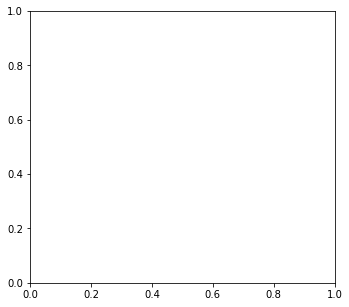

In [63]:
# 12-mo running mean minimum, mean and maximum of total area bias for all models

def running(op, v):
    return eval("v['time'][6:-5], v.rolling(time=12, center=True)."+op+"()[6:-5]")


cols = plt.get_cmap('nipy_spectral')
cols = plt.get_cmap('hsv')

cols = plt.get_cmap('plasma')

# cols = cm.cm.thermal
colsteps = min(20, len(ensemble))
linestyles = ['-', '--', ':', '-.']
lsstep = colsteps
lwidth = 1
for cycle in range(1, 2):
    plt.figure(1,(12,5))
    for c, k in enumerate(ensemble):
        ide = ice_data[k][cycle-1]
        cval = ((c)/colsteps)%1
        linestyle = linestyles[(c//lsstep) % len(linestyles)]
        plt.subplot(1,2,1)
        da = ide['NH_area'].copy(deep=True)
        for i, d in enumerate(da['time'].data):
            da['time'].data[i] = d.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
        v = da/1e12 - obs_ext_NH.area/1e12
        plt.plot(*running('max', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle, label=ide['desc'])
        plt.plot(*running('mean', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)
        plt.plot(*running('min', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)

        plt.subplot(1,2,2)
        v = ide['SH_area']/1e12 - obs_ext_SH.area/1e12
        plt.plot(*running('max', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle, label=ide['desc'])
        plt.plot(*running('mean', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)
        plt.plot(*running('min', v), color=cols(cval), linewidth=lwidth, linestyle=linestyle)

#     plt.subplot(1,2,1)
#     v = obs_ext_NH.area/1e12
#     plt.plot(*running('max', v), color='k', linewidth=2*lwidth, label='Observations')
#     plt.plot(*running('mean', v), color='k', linewidth=2*lwidth)
#     plt.plot(*running('min', v), color='k', linewidth=2*lwidth)

#     plt.subplot(1,2,2)
#     v = obs_ext_SH.area/1e12
#     plt.plot(*running('max', v), color='k', linewidth=2*lwidth, label='Observations')
#     plt.plot(*running('mean', v), color='k', linewidth=2*lwidth)
#     plt.plot(*running('min', v), color='k', linewidth=2*lwidth)

    plt.subplot(1,2,1)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
    plt.title('Arctic ice area min, mean and max, cycle ' + str(cycle))
    plt.subplot(1,2,2)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
    plt.title('Antarctic ice area min, mean and max, cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=-(-len(ensemble)//25))

    plt.tight_layout()
    
#     fname = os.path.join('figs', 'ice_area_min_mean_max_all_cycle'+str(cycle)+'.pdf')
    fname = 'ice_area_min_mean_max_param.pdf'

#     plt.savefig(fname, bbox_inches='tight')
#     plt.close()

In [53]:
da['time']

<xarray.DataArray 'time' (time: 612)>
array([cftime.DatetimeGregorian(1968, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1968, 3, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeGregorian(2018, 10, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2018, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2018, 12, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1968-01-01 00:00:00 ... 2018-12-01 00:00:00

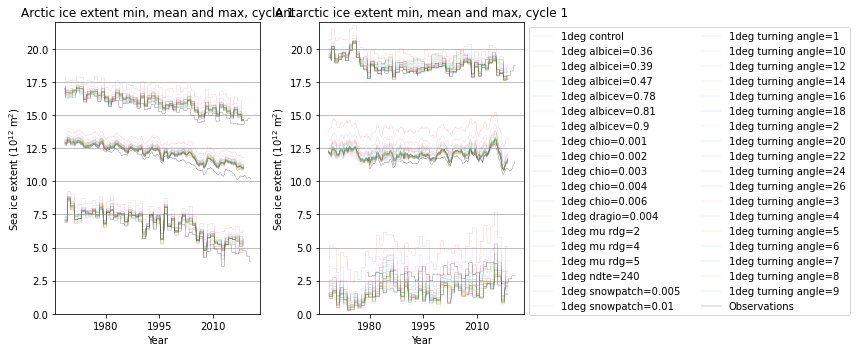

In [52]:
# 12-mo running mean minimum, mean and maximum of extent for all models
for cycle in range(1, 2):
    plt.figure(1,(12,5))
    for c, e in enumerate(ice_data.values()):
        try:
            ide = e[cycle-1]
            plt.subplot(1,2,1)
            v = ide['NH_extent']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=.1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=.1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=.1)

            plt.subplot(1,2,2)
            v = ide['SH_extent']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=.1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=.1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=.1)
        except:
            pass

    plt.subplot(1,2,1)
    v = obs_ext_NH.extent/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=.2, label='Observations')
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=.2)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=.2)

    plt.subplot(1,2,2)
    v = obs_ext_SH.extent/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=.2, label='Observations')
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=.2)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=.2)

    plt.subplot(1,2,1)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)')
    plt.title('Arctic ice extent min, mean and max, cycle ' + str(cycle))
    plt.subplot(1,2,2)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)')
    plt.title('Antarctic ice extent min, mean and max, cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=-(-len(ice_data.values())//25))

    plt.tight_layout()
    
#     fname = os.path.join('figs', 'ice_extent_min_mean_max_all_cycle'+str(cycle)+'.pdf')

    fname = 'ice_extent_min_mean_max_param.pdf'

    plt.savefig(fname, bbox_inches='tight')
#     plt.close()

## Timeseries of each month
Formatted to match left two columns of [Tsujino et al., 2020](https://doi.org/10.5194/gmd-13-3643-2020) fig 22:

![](https://gmd.copernicus.org/articles/13/3643/2020/gmd-13-3643-2020-f22.png)

In [42]:
# timeseries for each month for all models

for var, obs in zip(['SH_extent', 'NH_extent'], [obs_ext_SH.extent, obs_ext_NH.extent]):
    hem = var.split('_')[0]
    for m in range(1,13):
        fname = os.path.join('figs', '_'.join([var, yearrange, 'month', str(m).zfill(2)])+'.pdf')
        if False: #os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            print('doing', fname)
            plt.figure(1,(6,3))
            for cycle in range(1, 7):
                for c, e in enumerate(ice_data.values()):
                    try:
                        ide = e[cycle-1]
                        v = ide[var]/1e12
                        if cycle == 1:
                            plt.plot(v['time'].sel(time=(v['time.month']==m)),
                                     v.sel(time=(v['time.month']==m)),
                                     color='C'+str(c), linewidth=1, label=ide['desc'])
                        else:
                            plt.plot(v['time'].sel(time=(v['time.month']==m)),
                                     v.sel(time=(v['time.month']==m)),
                                     color='C'+str(c), linewidth=1) #, label=ide['desc'])
                    except:
                        pass

            v = obs/1e12
            plt.plot(v['time'].sel(time=(v['time.month']==m)),
                     v.sel(time=(v['time.month']==m)),
                     color='k', linewidth=4, label='NSIDC_SII obs')
            

# set axis limits to match Tsujino et al (2020) fig 22
            plt.xlim([cftime.DatetimeGregorian(1948, 1, 1), cftime.DatetimeGregorian(2019, 1, 1)])
            if hem == 'NH':
                if m == 3:
                    plt.yticks(np.arange(10, 21, 2))
                    plt.ylim(ymin=10, ymax=20)
                elif m == 9:
                    plt.yticks(np.arange(0, 11, 2))
                    plt.ylim(ymin=0, ymax=10)
            else:
                if m == 3:
                    plt.yticks(np.arange(0, 7, 2))
                    plt.ylim(ymin=0, ymax=7)
                elif m == 9:
                    plt.yticks(np.arange(10, 26, 5))
                    plt.ylim(ymin=12, ymax=27)
            plt.grid(axis='x')
            plt.grid(axis='y')
            plt.xlabel('Year')
            plt.ylabel(r'Sea ice extent (10$^{6}$ km$^2$)')
            plt.title(' '.join([calendar.month_name[m], hem]))
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

            plt.tight_layout()

            plt.savefig(fname, bbox_inches='tight')
            plt.close()
#             break
#     break

doing figs/SH_extent_1958-2018_month_01.pdf
doing figs/SH_extent_1958-2018_month_02.pdf
doing figs/SH_extent_1958-2018_month_03.pdf
doing figs/SH_extent_1958-2018_month_04.pdf
doing figs/SH_extent_1958-2018_month_05.pdf
doing figs/SH_extent_1958-2018_month_06.pdf
doing figs/SH_extent_1958-2018_month_07.pdf
doing figs/SH_extent_1958-2018_month_08.pdf
doing figs/SH_extent_1958-2018_month_09.pdf
doing figs/SH_extent_1958-2018_month_10.pdf
doing figs/SH_extent_1958-2018_month_11.pdf
doing figs/SH_extent_1958-2018_month_12.pdf
doing figs/NH_extent_1958-2018_month_01.pdf
doing figs/NH_extent_1958-2018_month_02.pdf
doing figs/NH_extent_1958-2018_month_03.pdf
doing figs/NH_extent_1958-2018_month_04.pdf
doing figs/NH_extent_1958-2018_month_05.pdf
doing figs/NH_extent_1958-2018_month_06.pdf
doing figs/NH_extent_1958-2018_month_07.pdf
doing figs/NH_extent_1958-2018_month_08.pdf
doing figs/NH_extent_1958-2018_month_09.pdf
doing figs/NH_extent_1958-2018_month_10.pdf
doing figs/NH_extent_1958-2018_m

### Mean seasonal cycle of area and extent

In [35]:
# seasonal cycle of area for all models
for cycle in range(1, 7):
    plt.figure(1,(12,5))
    for c, e in enumerate(ice_data.values()):
        try:
            ide = e[cycle-1]
            plt.subplot(2,1,1)
            v = ide['NH_area']/1e12
            v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ide['desc'])

            plt.subplot(2,1,2)
            v = ide['SH_area']/1e12
            v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ide['desc'])
        except:
            pass
    plt.subplot(2,1,1)
    v = obs_ext_NH.area/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

    plt.subplot(2,1,2)
    v = obs_ext_SH.area/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

    plt.subplot(2,1,1)
    plt.ylim(ymin=0,ymax=22)
    plt.xlabel('Month')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
    plt.title('Arctic sea ice area '+yearrange+' mean annual cycle, for JRA55-do cycle ' + str(cycle))
    plt.subplot(2,1,2)
    plt.ylim(ymin=0,ymax=22)
    plt.xlabel('Month')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
    plt.title('Antarctic sea ice area '+yearrange+' mean annual cycle, for JRA55-do cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    fname = os.path.join('figs', 'ice_area_seasonal_clim_cycle'+str(cycle)+'.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

In [46]:
# seasonal cycle of extent for all models
for cycle in range(1, 7):

    plt.figure(1,(12,5))
    for c, e in enumerate(list(ice_data.values())[0:3]):
        try:
            ide = e[cycle-1]
            plt.subplot(2,1,1)
            v = ide['NH_extent']/1e12
            v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ide['desc'])

            plt.subplot(2,1,2)
            v = ide['SH_extent']/1e12
            v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ide['desc'])
        except:
            pass

    plt.subplot(2,1,1)
    v = obs_ext_NH.extent/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='k', linewidth=2, label='Observations')

    plt.subplot(2,1,2)
    v = obs_ext_SH.extent/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='k', linewidth=2, label='Observations')

    plt.subplot(2,1,1)
    plt.ylim(ymin=0,ymax=22)
    plt.xlabel('Month')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)')
    plt.title('Arctic sea ice extent '+yearrange+' mean annual cycle, for JRA55-do cycle ' + str(cycle))
    plt.subplot(2,1,2)
    plt.ylim(ymin=0,ymax=22)
    plt.xlabel('Month')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^23$)')
    plt.title('Antarctic sea ice extent '+yearrange+' mean annual cycle, for JRA55-do cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    fname = os.path.join('figs', 'ice_extent_seasonal_clim_cycle'+str(cycle)+'.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

In [46]:
# seasonal cycle of extent for all models
for cycle in range(1, 7):

    plt.figure(1,(12,5))
    for c, e in enumerate(list(ice_data.values())[0:3]):
        try:
            ide = e[cycle-1]
            plt.subplot(2,1,1)
            v = ide['NH_extent']/1e12
            v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ide['desc'])

            plt.subplot(2,1,2)
            v = ide['SH_extent']/1e12
            v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
            plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ide['desc'])
        except:
            pass

    plt.subplot(2,1,1)
    v = obs_ext_NH.extent/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='k', linewidth=2, label='Observations')

    plt.subplot(2,1,2)
    v = obs_ext_SH.extent/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='k', linewidth=2, label='Observations')

    plt.subplot(2,1,1)
    plt.ylim(ymin=0,ymax=22)
    plt.xlabel('Month')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)')
    plt.title('Arctic sea ice extent '+yearrange+' mean annual cycle, for JRA55-do cycle ' + str(cycle))
    plt.subplot(2,1,2)
    plt.ylim(ymin=0,ymax=22)
    plt.xlabel('Month')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^23$)')
    plt.title('Antarctic sea ice extent '+yearrange+' mean annual cycle, for JRA55-do cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    fname = os.path.join('figs', 'ice_extent_seasonal_clim_cycle'+str(cycle)+'.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

### Mean seasonal cycle of volume terms
units: cm/day for all of
- dvidtd_m
- dvidtt_m
- congel_m
- frazil_m
- meltt_m
- meltb_m
- meltl_m
- snoice_m
- evap_ai_m           ** NB: ai - so this is a grid-cell mean, like all the others **



In [83]:
# volume tendency terms due to thermo (and dynamics)
terms = ['congel_m', 'frazil_m', 'meltt_m', 'meltb_m', 'meltl_m', 'snoice_m', 'evap_ai_m', 'dvidtt_m'] #, 'dvidtd_m']

In [84]:
monthdays = [ calendar.monthrange(2001, m)[1] for m in range(1, 13) ] # not a leap year
rhoi = 917.0 # CICE ice density (kg/m^3)

In [85]:
def calcterms(ide, varnames=terms, timerange=timerange):
    loaddata(ide, varnames=varnames, timerange=timerange)
    for var in varnames:
        print(var)
        if 'NH_'+var not in ide.keys():
            vol = ide[var]*ide['area_t']
            vol_zonalsum = vol.sum('xt_ocean').compute()  # do this once for both NH & SH
            vol_zonalsum = vol_zonalsum/100*rhoi  # convert to kg/day
            if var in ['meltt_m', 'meltb_m', 'meltl_m']:
                vol_zonalsum = -vol_zonalsum
            ide['NH_'+var] = vol_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
            ide['SH_'+var] = vol_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
            # monthly climatologies are in kg/month
            ide['NH_'+var+'_clim'] = ide['NH_'+var].sel(time=timerange).groupby('time.month').mean('time', skipna=True)*monthdays
            ide['SH_'+var+'_clim'] = ide['SH_'+var].sel(time=timerange).groupby('time.month').mean('time', skipna=True)*monthdays

In [86]:
for ekey in ensemble:
    for ide in ice_data[ekey]:
        calcterms(ide)

congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
meltt_m
meltb_m
meltl_m
snoice_m
evap_ai_m
dvidtt_m
congel_m
frazil_m
me

In [87]:
control = controlkeys[0]  # KLUDGE! do this better!
for ekey in ensemble:
    for cycle, ide in enumerate(ice_data[ekey], start=1):
        idecontrol = ice_data[control][cycle-1]
        title = 'Antarctic sea ice mass balance '+yearrange+' mean annual cycle for '+ide['desc']
        fname = '_'.join(['SH', ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                          yearrange, 'mass_terms_seasonal_clim'])
        pngfname = os.path.join(figdir, fname+'_'+str(dpi)+'dpi.png')
        pdffname = os.path.join(figdir, fname+'.pdf')
        if os.path.exists(pngfname):
            print('   -- skipping', fname)
        else:
            print('doing '+fname)
            plt.figure(figsize=(10, 8))
            if not ekey == control:
                for n, var in enumerate(terms):
                    v = idecontrol['SH_'+var+'_clim']/1e15
                    plt.plot(v['month'], v, '--', color='C'+str(n), linewidth=1)
            for n, var in enumerate(terms):
                if var == 'dvidtt_m':
                    label = 'net thermo tendency'
                else:
                    label = ide[var].long_name
                v = ide['SH_'+var+'_clim']/1e15
                plt.plot(v['month'], v, color='C'+str(n), linewidth=2, label=label)
            plt.plot([1,12], [0, 0], '-k', linewidth=0.5)  # zero line
            plt.xlabel('Month')
            plt.ylabel(r'Sea ice mass tendency (10$^{15}$ kg/month)')
            plt.xlim(xmin=1, xmax=12)
            plt.ylim(ymin=-6, ymax=3)
            plt.legend(loc='lower center')
            plt.title(title)
            plt.savefig(pngfname, dpi=dpi, bbox_inches='tight')
            plt.savefig(pdffname, dpi=dpi, bbox_inches='tight')
            plt.close()


doing SH_1deg_jra55_iaf_ensemble_albicei_0.36_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_albicei_0.39_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_albicei_0.47_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_albicev_0.78_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_albicev_0.81_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_albicev_0.9_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_chio_0.001_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_chio_0.002_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_chio_0.003_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_chio_0.004_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_chio_0.006_cycle1_1993-2017_mass_terms_seasonal_clim
doing SH_1deg_jra55_iaf_ensemble_cycle1_199

## TODO: Mean seasonal cycle of area terms